In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
#!pip install pmdarima
import pmdarima as pm
from pmdarima.arima import auto_arima


In [2]:
#from pandas_datareader import data as pdr
import datetime as dt

import yfinance as yf

In [3]:
#legacy code from LSTM to retrieve prices
class price_volume_data:
    """A class for retrieving and analyzing price and volume data."""
    def __init__(self, tickers, start_date, end_date):
        """
        Initializes a new instance of the price_volume_data class.

        Args:
            tickers (list): A list of tickers for the assets to retrieve data for.
            start_date (str): The start date for the data retrieval (format: 'YYYY-MM-DD').
            end_date (str): The end date for the data retrieval (format: 'YYYY-MM-DD').
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.pv = self.__retrieve_data__()
        #self.lp, self.ret = self.__get_daily_returns__() #didn't need daily returns
        
    def __retrieve_data__(self):
        """
        Retrieves price and volume data for the given tickers from Yahoo Finance API.

        Returns:
            dict: A dictionary containing the price and volume data for each ticker.
        """

        data, failed = {}, []
        for ticker in self.tickers:
            try:
                df = yf.Ticker(ticker).history(start = self.start_date, end = self.end_date)
                
                data[ticker] = df
                
            except:
                failed.append(ticker)
                
        if failed:
            print('Tickers failed to extract: ', failed)
        
        return data
    
    def __get_daily_returns__(self):
        """
        Computes daily returns for the retrieved price data.

        Returns:
            pd.DataFrame: A DataFrame containing the daily price data.
            pd.DataFrame: A DataFrame containing the daily price returns.
        """
        df = pd.DataFrame()
        
        for ticker in self.pv:
            if df.empty:
                df = pd.DataFrame(self.pv[ticker]['Close'].copy())
            else:
                df = df.merge(self.pv[ticker]['Close'], how='outer',left_index=True, right_index=True)

        df.columns = self.tickers
        df = df.fillna(method = 'ffill')
        
        return df, df/df.shift(1) - 1
    
    def get_info(self, ticker = None):
        """
        Prints information about the price and volume data for the specified ticker.
        If no ticker is provided, prints information for all tickers.

        Args:
            ticker (str, optional): The ticker symbol for the asset. Defaults to None.
        """
        if ticker:
            self.pv[ticker].info()
        
        else:
            for ticker in self.pv:
                self.pv[ticker].info()
                
        return None
    
    def plot_price_trends(self, normalize = True, reference = -1):
        """
        Plots the close prices of selected assets over time.

        Args:
            normalize (bool, optional): Indicates whether to normalize the prices. Defaults to True.
            reference (int, optional): Reference point for normalization. Defaults to -1.
        """
        f, ax = plt.subplots(1,1,figsize=(12,5))
        # plot prices
        for key in self.pv:
            last_price = self.pv[key].loc[:, 'Close'].copy()
            if normalize:
                if reference == -1:
                    last_price /= last_price.iloc[0]
                elif reference == 0:
                    midpt = int(last_price.shape[0]/2)
                    last_price /= last_price.iloc[midpt]
                else:
                    last_price /= last_price.iloc[-1]
            last_price.plot(ax = ax, label = key)
        
        ax.title.set_text('Close Prices of selected assets')
        ax.set(ylabel = 'Normalized Price to start of observation')
        ax.legend()
        plt.show()
        
    def plot_corr(self, method='pearson', output = False, series = 'price'):
        """
        Plots the correlation matrix between asset prices or returns.

        Args:
            method (str, optional): The correlation method to use. Defaults to 'pearson'.
            output (bool, optional): Indicates whether to return the correlation matrix. Defaults to False.
            series (str, optional): Indicates whether to use 'price' or 'returns'. Defaults to 'price'.

        Returns:
            pd.DataFrame or None: The correlation matrix if output=True, None otherwise.
        """
        corr_matrix = self.lp.corr(method) if series == 'price' else self.ret.corr(method)
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        f, ax = plt.subplots(figsize=(5, 5))
        sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True)
        
        return corr_matrix if output else None
        
        
    def get_technical_indicators(self, indicators = None, normalize = True):
        """
        Computes and adds various technical indicators to the price data.

        Args:
            indicators (list, optional): A list of tuples specifying the indicators and their parameters.
                Defaults to None.
            normalize (bool, optional): Indicates whether to normalize the indicator values. Defaults to True.
        """
        if not indicators:
            indicators = [('SMA', 5), ('SMA', 14), ('ATR', 5), ('ATR', 14), ('ADX', 5),
                         ('ADX', 14), ('RSI', 5), ('RSI', 14), ('MACD', None), ('BBANDS', None)]
        
        for data in self.pv:
            df = self.pv[data]
            for indicator, param in indicators:
                
                if indicator == 'SMA':
                    df[f'{indicator}_{param}'] = talib.SMA(df['Close'], param)

                elif indicator == 'ATR':
                    df[f'{indicator}_{param}'] = talib.ATR(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'ADX':
                    df[f'{indicator}_{param}'] = talib.ADX(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'RSI':
                    df[f'{indicator}_{param}'] = talib.RSI(df['Close'], param) 
                    
                elif indicator == 'MACD':
                    df[f'{indicator}'], df[f'{indicator}_signal'], _ = talib.MACD(df['Close']) 
                    
                    
                elif indicator == 'BBANDS':
                    df[f'{indicator}_upp'], df[f'{indicator}_mid'], df[f'{indicator}_low'] = talib.BBANDS(df['Close'])
                    
                    
                else:
                    print('Indicators not built into the class. Please run TALIB manually!')
            
            df = df.replace([np.inf, -np.inf], np.nan, inplace = True)
            
        return None              

In [4]:
sheet_name = ['20220524','20220823','20221122','20230221','20230523']
symbols = pd.read_excel("target_stock_universe.xlsx", sheet_name = sheet_name[0]) # change here to get the other sheet
symbols['Ticker_Symbol'] = symbols['Ticker'].str.split().str[0]+".L"
symbols = symbols[symbols['Ticker_Symbol']!='HSV.L']
symbols = symbols[symbols['Ticker_Symbol']!='HBR.L']


symbols_short = symbols['Ticker_Symbol']
symbols_short

0      ICP.L
1     ABDN.L
2     SMDS.L
4       HL.L
5      DPH.L
6      HIK.L
7     HWDN.L
8      IDS.L
9      ITV.L
10     CCL.L
11    INVP.L
12     CNA.L
13    CTEC.L
14     UTG.L
15    JMAT.L
16    WEIR.L
18    BBOX.L
19     EZJ.L
20     IMI.L
21     DLN.L
22     TUI.L
23     SXS.L
24     HSX.L
25     DLG.L
26     EMG.L
27    DPLM.L
28     IGG.L
29    WIZZ.L
30    FRAS.L
31    TATE.L
32     BEZ.L
33     PNN.L
34     RSW.L
Name: Ticker_Symbol, dtype: object

In [5]:
data = price_volume_data(symbols_short.to_list(),'2017-05-25', '2022-05-31')
data.pv

{'ICP.L':                                   Open         High          Low        Close  \
 Date                                                                            
 2017-05-25 00:00:00+01:00   632.439086   728.545025   629.927938   713.044067   
 2017-05-26 00:00:00+01:00   712.269068   725.057359   688.630106   691.342773   
 2017-05-30 00:00:00+01:00   687.080036   694.442992   681.267177   682.429749   
 2017-05-31 00:00:00+01:00   681.654593   687.854976   680.492021   683.979736   
 2017-06-01 00:00:00+01:00   685.917335   694.055337   679.716952   686.692383   
 ...                                ...          ...          ...          ...   
 2022-05-24 00:00:00+01:00  1312.555141  1337.080392  1308.921770  1323.909424   
 2022-05-25 00:00:00+01:00  1344.347116  1344.347116  1307.105067  1324.817749   
 2022-05-26 00:00:00+01:00  1379.318205  1451.531440  1372.051465  1425.643677   
 2022-05-27 00:00:00+01:00  1419.285366  1457.889927  1417.014509  1449.714844   
 2022-0

In [6]:
#data wrangling
#objective is to have a dataframe of close prices. columns = stocks and rows = price observations (time series)

df = data.pv[symbols_short[0]]["Close"]
for stock in symbols_short[1:]:
    
    df = pd.concat([df, data.pv[stock]["Close"]], axis = 1)

df.columns = symbols_short
df.index = pd.to_datetime(df.index.date)

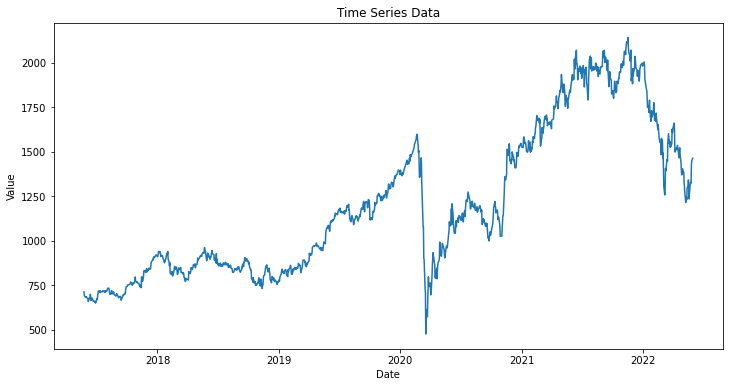

ADF Statistic: -1.6725935616562657
p-value: 0.4452855236646185
Critical Values:
1%: -3.43554227494792
5%: -2.8638329319593185
10%: -2.5679907811664124
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12179.400, Time=3.57 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12181.396, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12181.396, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12177.910, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12181.662, Time=0.56 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.511 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6087.955
Date:                Thu, 12 Oct 2023   AIC                          12177.910
Time:                        12:58:24   BIC      

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


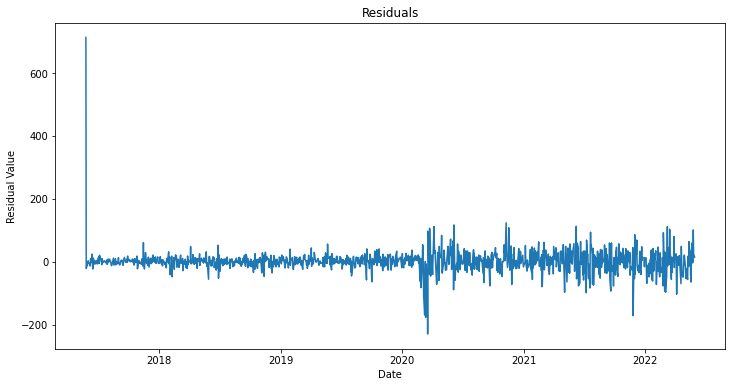

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


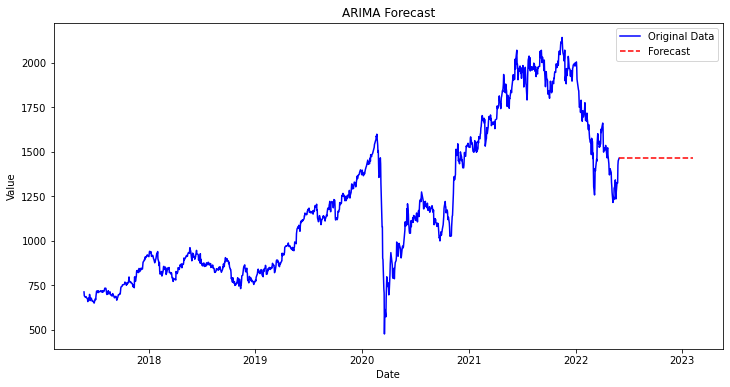

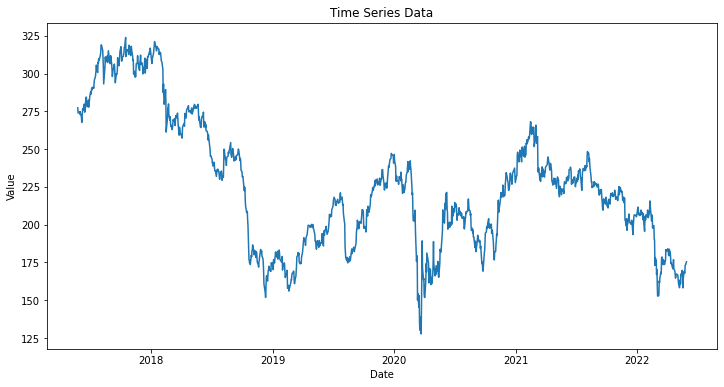

ADF Statistic: -1.8615205675060835
p-value: 0.350373810537825
Critical Values:
1%: -3.435550533536195
5%: -2.863836575823745
10%: -2.567992721718317
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7337.712, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7338.818, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7338.832, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7336.141, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7340.363, Time=0.33 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.679 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3667.071
Date:                Thu, 12 Oct 2023   AIC                           7336.141
Time:                        12:58:26   BIC             

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


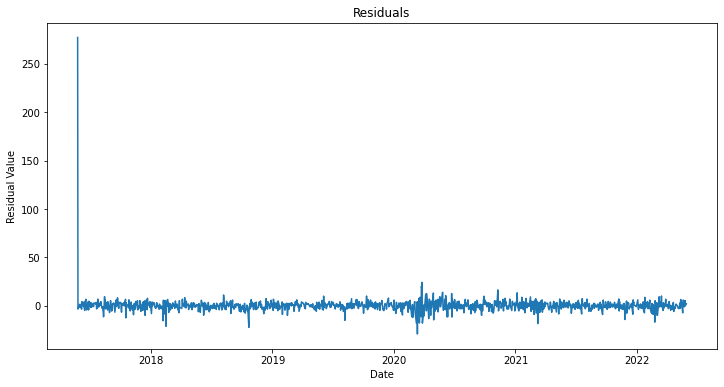

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


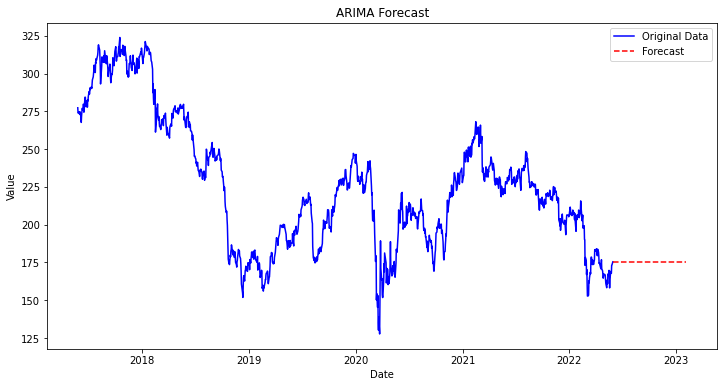

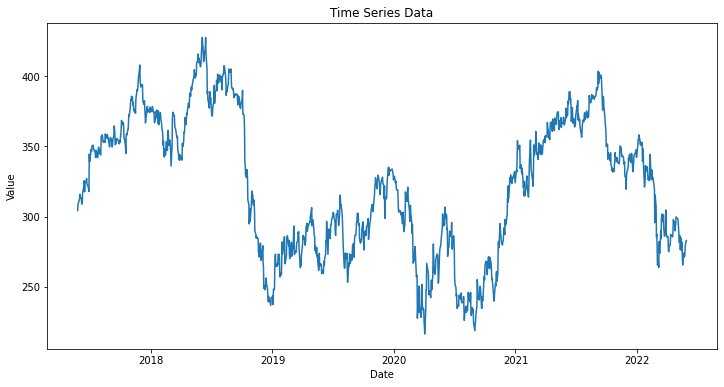

ADF Statistic: -2.1726935463798362
p-value: 0.2163049469299903
Critical Values:
1%: -3.4355217427788793
5%: -2.8638238726872296
10%: -2.5679859566283705
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8166.375, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8167.009, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8166.957, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8164.385, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8167.330, Time=0.32 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.698 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4081.193
Date:                Thu, 12 Oct 2023   AIC                           8164.385
Time:                        12:58:28   BIC         

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


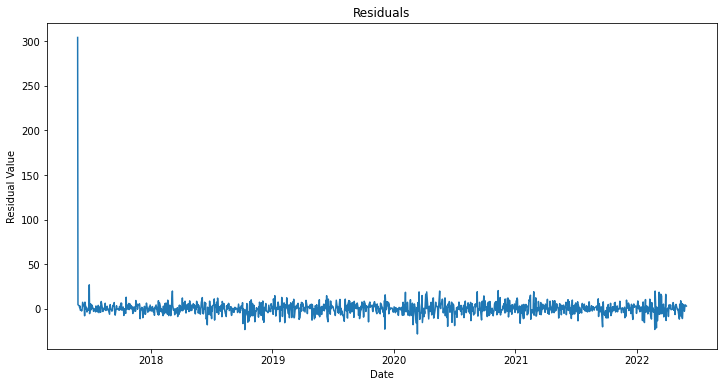

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


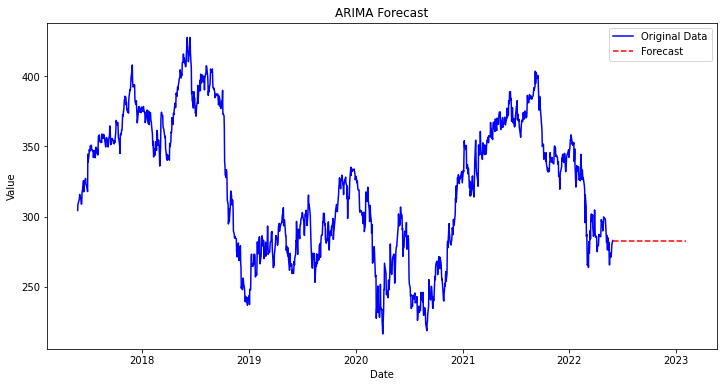

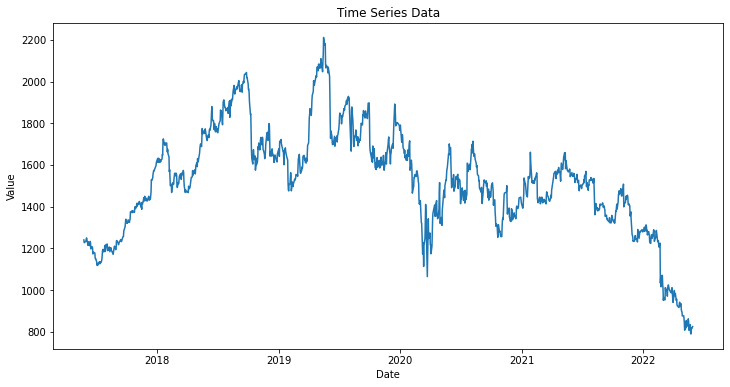

ADF Statistic: -1.7305844848399432
p-value: 0.4154272909345358
Critical Values:
1%: -3.4355588184378574
5%: -2.8638402312881497
10%: -2.5679946684494275
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12396.081, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12397.783, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12397.770, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12394.213, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12399.726, Time=0.52 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.952 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6196.107
Date:                Thu, 12 Oct 2023   AIC                          12394.213
Time:                        12:58:29   BIC    

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


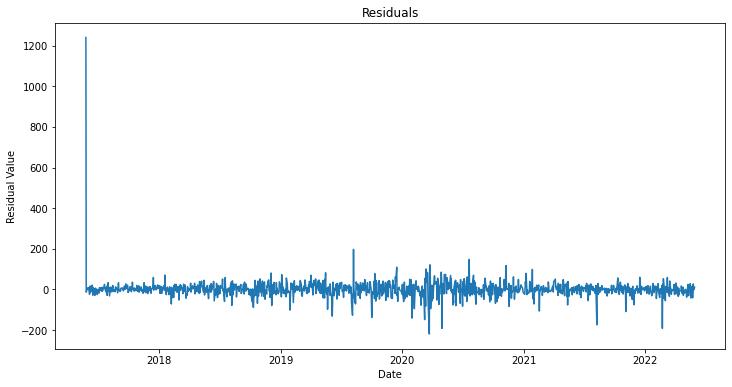

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


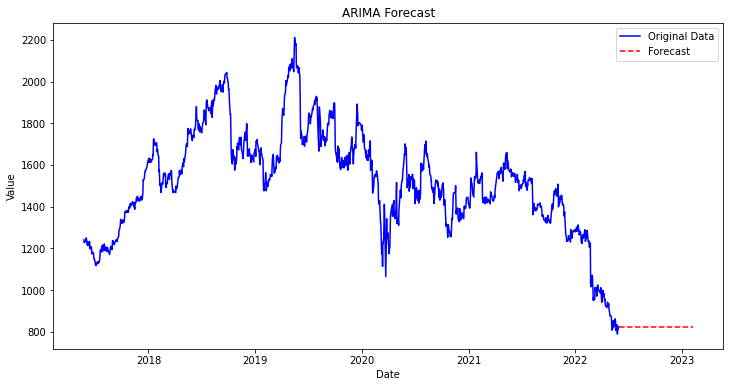

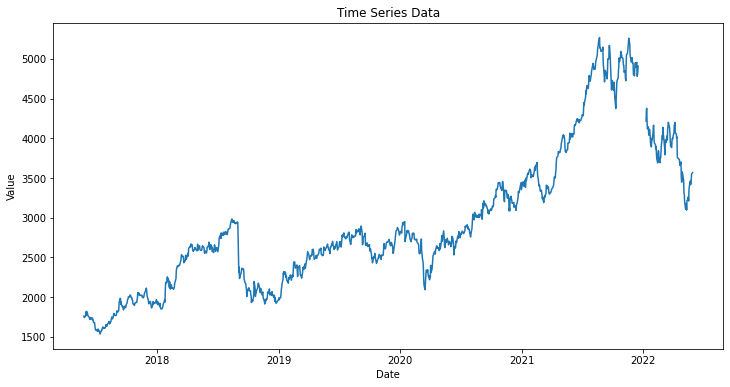

ADF Statistic: -1.4523125082823254
p-value: 0.5569561121188257
Critical Values:
1%: -3.4355629707955395
5%: -2.863842063387667
10%: -2.567995644141416
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13716.383, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13715.192, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13715.239, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13715.201, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13717.158, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13717.168, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13718.753, Time=1.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=13713.931, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=13715.890, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=13715.895, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=13713.980, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AI

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


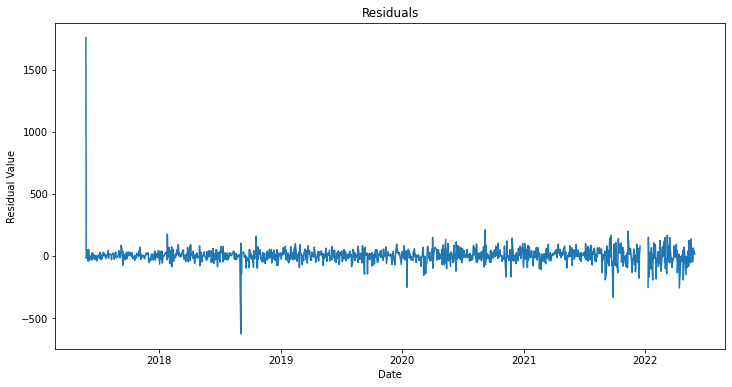

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


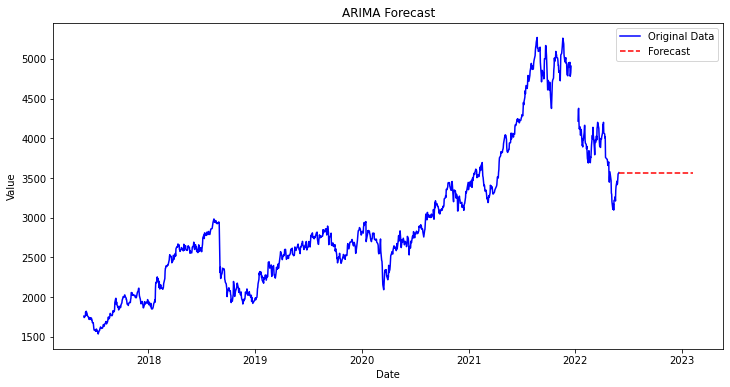

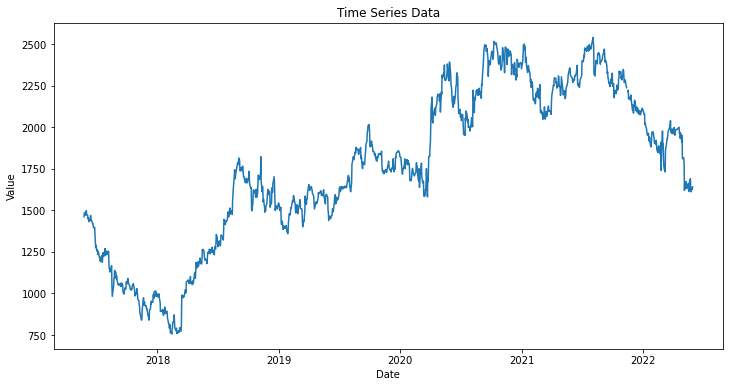

ADF Statistic: -1.4065876716572185
p-value: 0.5791138627710462
Critical Values:
1%: -3.4355258362116787
5%: -2.8638256788102323
10%: -2.567986918482913
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12642.234, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12642.193, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12642.076, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12640.254, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12642.683, Time=0.74 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.150 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1267
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6319.127
Date:                Thu, 12 Oct 2023   AIC                          12640.254
Time:                        12:58:35   BIC     

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


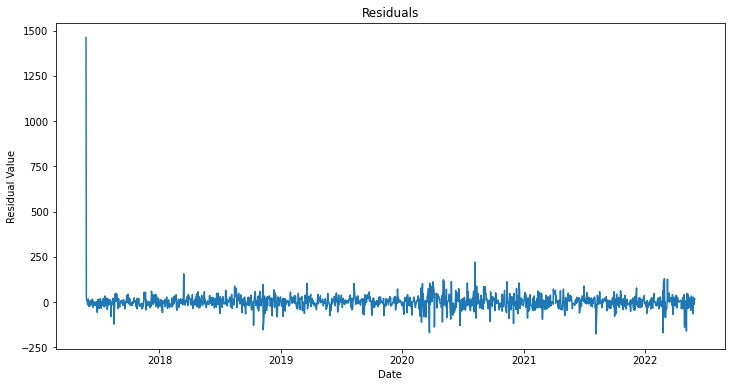

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


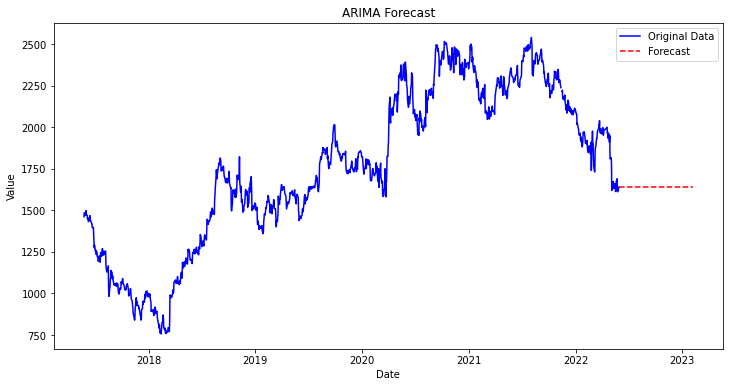

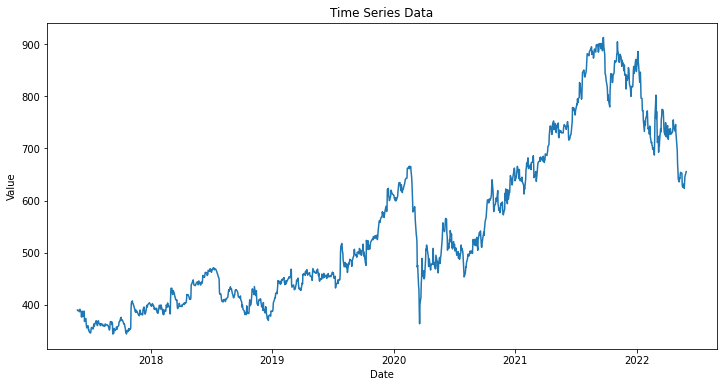

ADF Statistic: -1.2590984023618081
p-value: 0.6476710541018067
Critical Values:
1%: -3.435592223709696
5%: -2.8638549702604803
10%: -2.56800251776
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9436.456, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9435.595, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9435.808, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9435.012, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9436.832, Time=0.44 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.918 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4716.506
Date:                Thu, 12 Oct 2023   AIC                           9435.012
Time:                        12:58:37   BIC               

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


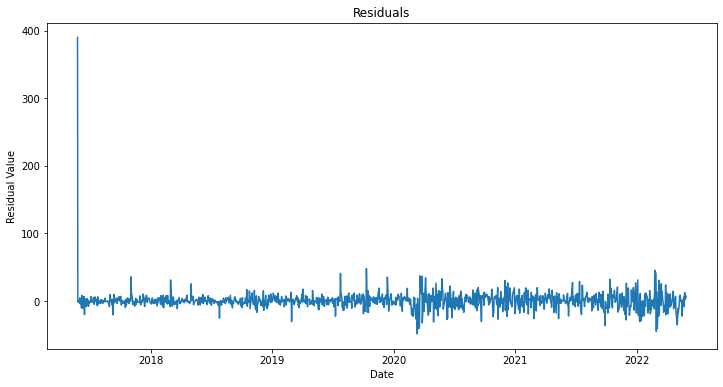

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


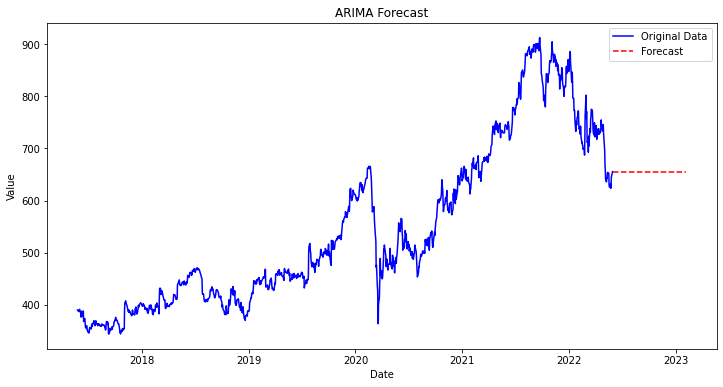

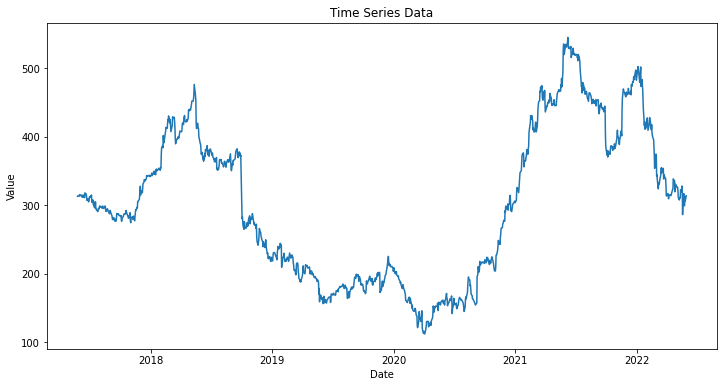

ADF Statistic: -1.0922558578270332
p-value: 0.7181502781268231
Critical Values:
1%: -3.4355217427788793
5%: -2.8638238726872296
10%: -2.5679859566283705
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8451.497, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8452.536, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8452.601, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8449.497, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8449.769, Time=0.61 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.032 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4223.748
Date:                Thu, 12 Oct 2023   AIC                           8449.497
Time:                        12:58:39   BIC         

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


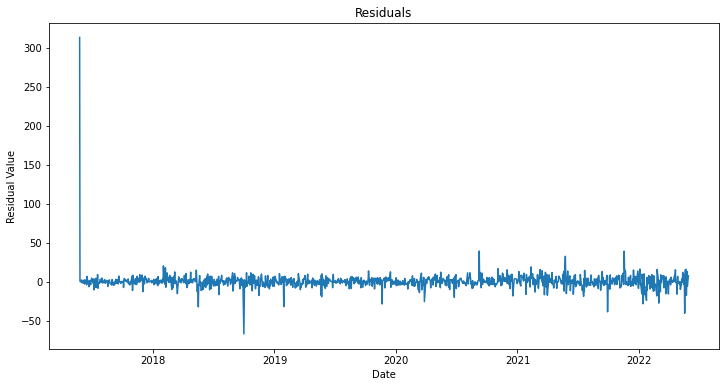

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


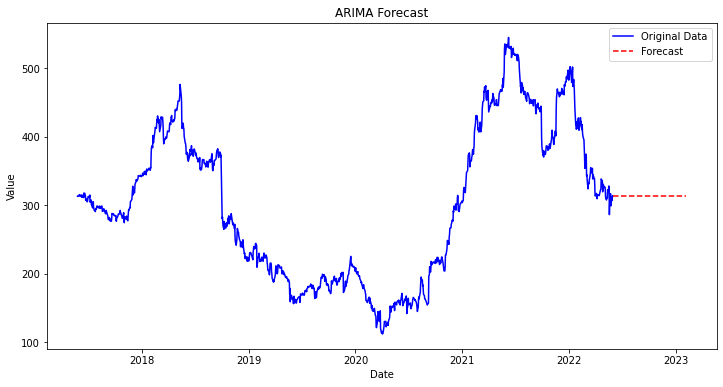

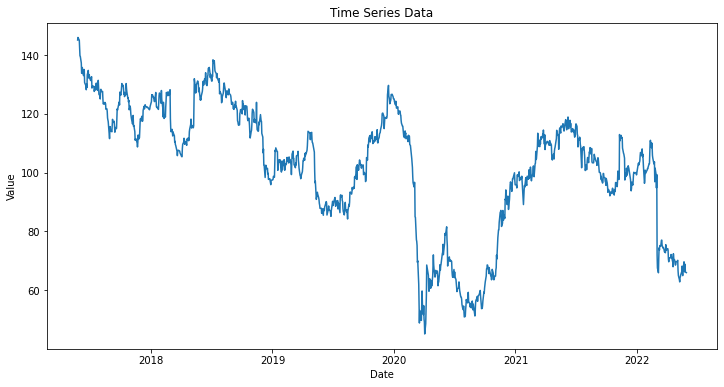

ADF Statistic: -2.01661315681993
p-value: 0.2793366490927088
Critical Values:
1%: -3.4355217427788793
5%: -2.8638238726872296
10%: -2.5679859566283705
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5659.549, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5661.542, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5661.542, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5658.520, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5662.081, Time=0.84 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.271 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2828.260
Date:                Thu, 12 Oct 2023   AIC                           5658.520
Time:                        12:58:41   BIC           

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


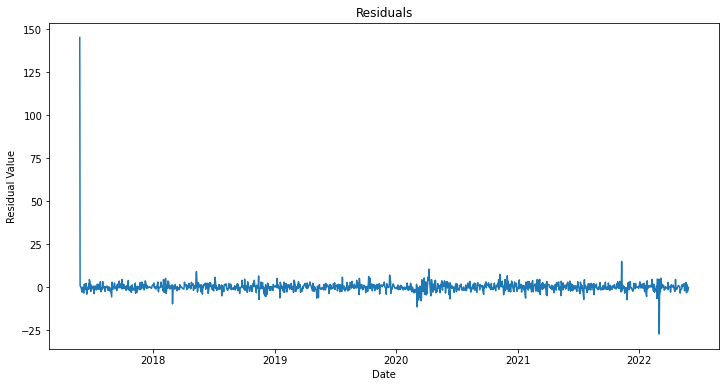

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


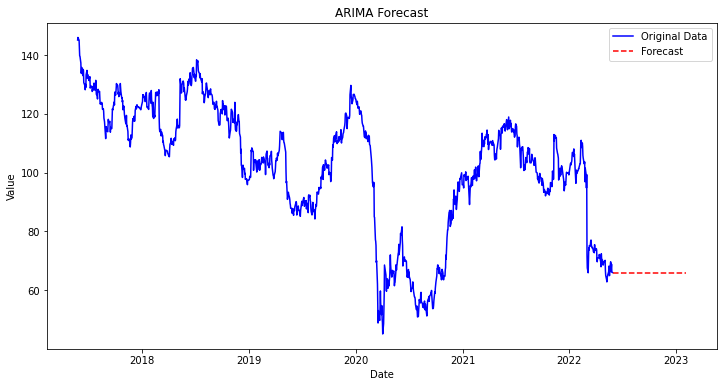

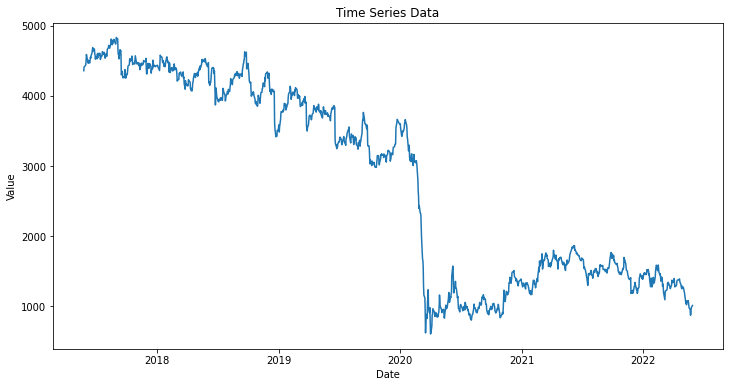

ADF Statistic: -1.0869928680179854
p-value: 0.7202310276297077
Critical Values:
1%: -3.4355796466416777
5%: -2.863849421064024
10%: -2.5679995625056926
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14115.853, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14113.941, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14114.201, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14116.048, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=14114.371, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14114.131, Time=0.49 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14116.061, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=14113.897, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=14114.186, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=14113.832, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=14114.184, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : A

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


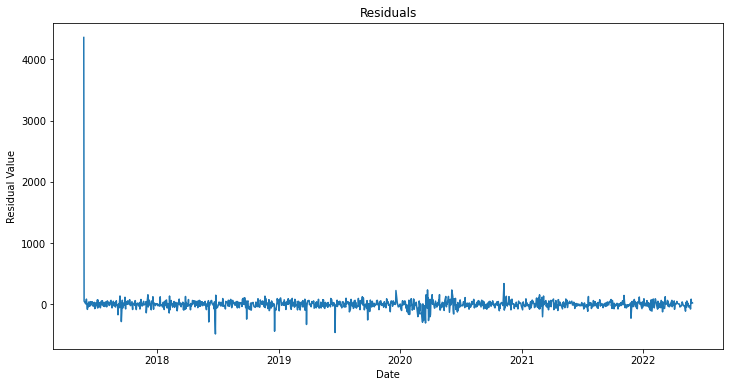

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


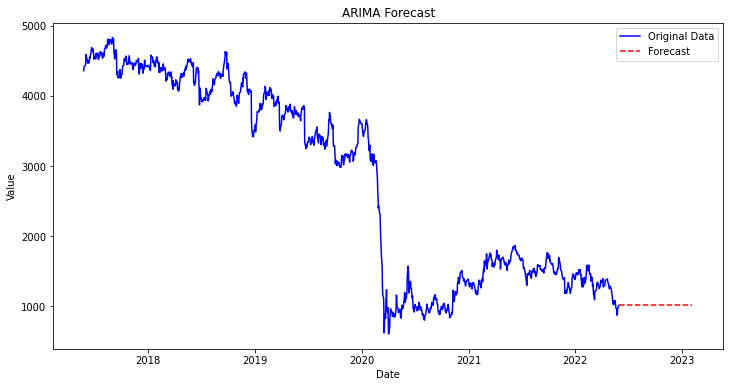

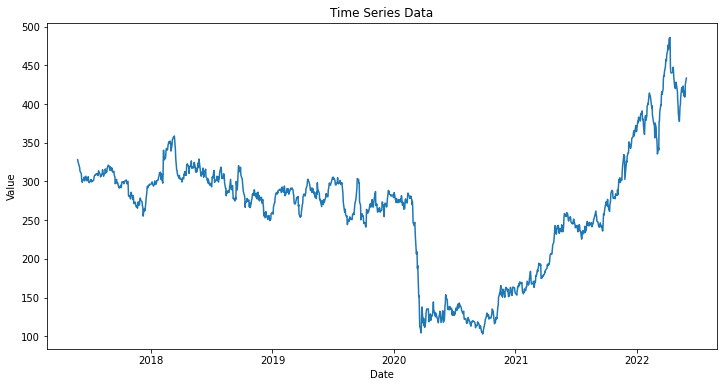

ADF Statistic: -0.7642198170212227
p-value: 0.8294070061384315
Critical Values:
1%: -3.4355340425478706
5%: -2.863829299639741
10%: -2.5679888467643406
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8027.184, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8029.095, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8029.107, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8025.450, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8024.465, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8022.175, Time=0.49 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8022.858, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=8023.470, Time=1.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8024.058, Time=0.94 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8022.401, Time=0.63 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=8022.449, Time=0.41 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8023.766

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


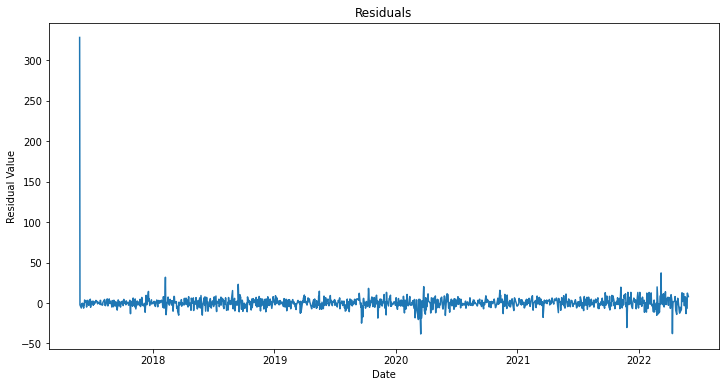

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


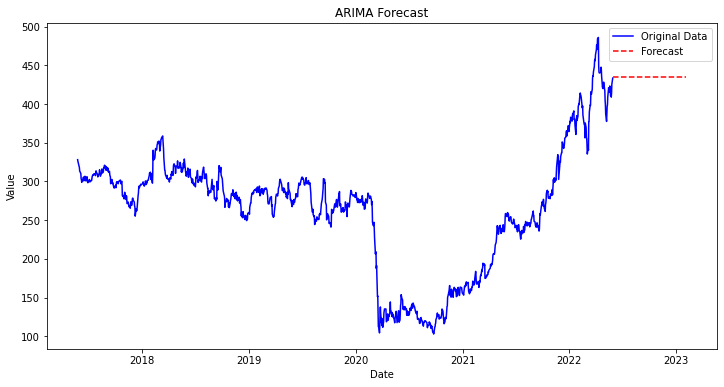

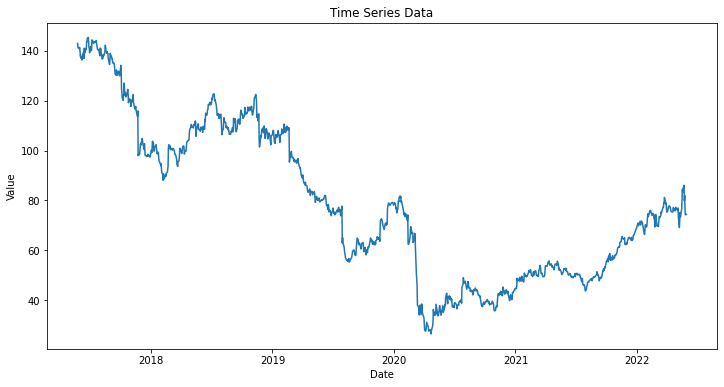

ADF Statistic: -2.101009461568878
p-value: 0.24410888572009604
Critical Values:
1%: -3.4355217427788793
5%: -2.8638238726872296
10%: -2.5679859566283705
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4920.025, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4921.918, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4921.914, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4919.335, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4923.722, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.571 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2458.667
Date:                Thu, 12 Oct 2023   AIC                           4919.335
Time:                        12:58:58   BIC         

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


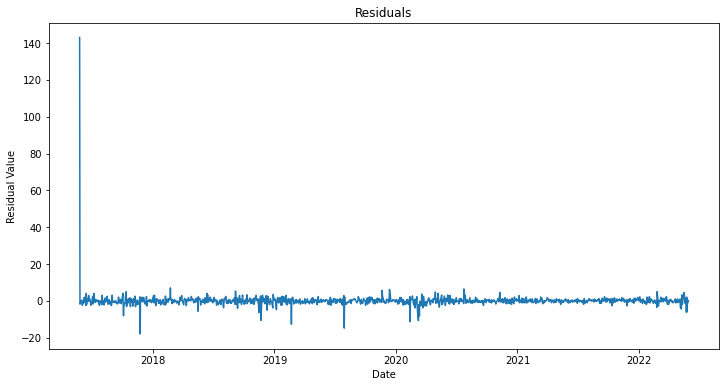

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


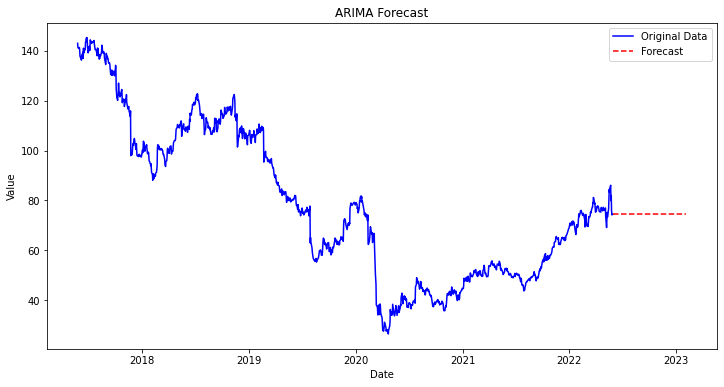

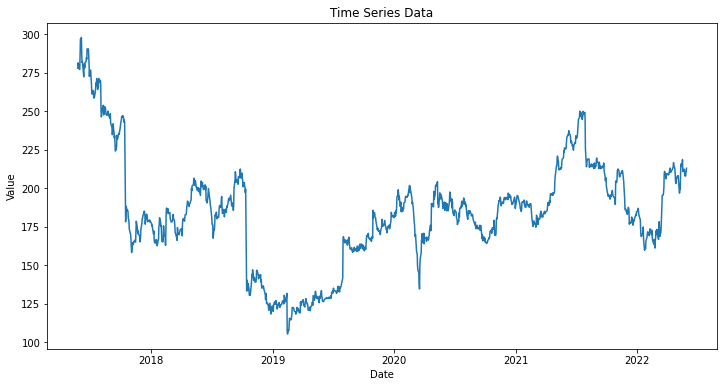

ADF Statistic: -2.89951423633046
p-value: 0.04540451434455637
Critical Values:
1%: -3.4355217427788793
5%: -2.8638238726872296
10%: -2.5679859566283705
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7260.383, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7261.196, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7261.241, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7258.569, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7263.073, Time=0.38 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.711 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3628.284
Date:                Thu, 12 Oct 2023   AIC                           7258.569
Time:                        12:59:00   BIC          

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


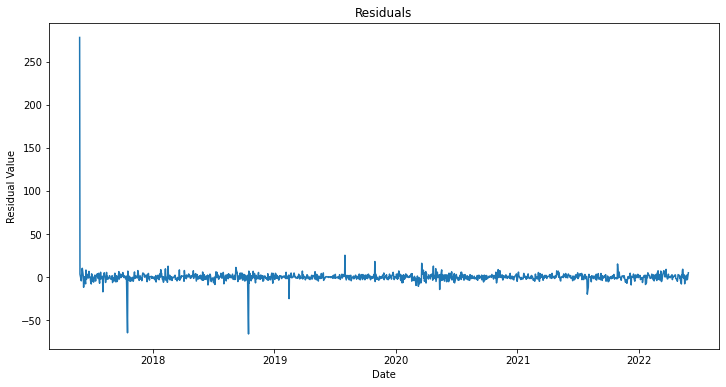

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


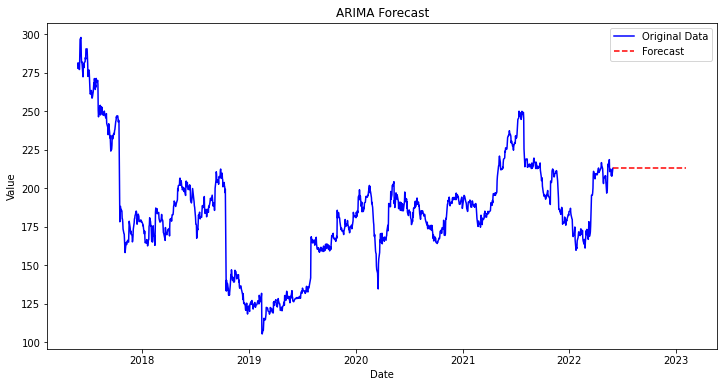

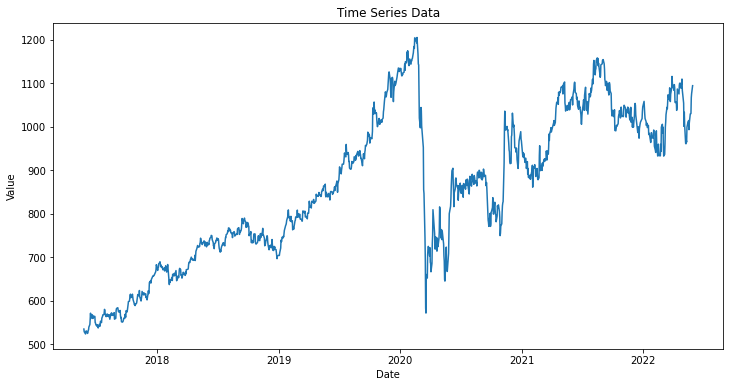

ADF Statistic: -1.9860191766025233
p-value: 0.29273664659264714
Critical Values:
1%: -3.435571295403709
5%: -2.863845736356174
10%: -2.567997600196822
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10533.318, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10518.336, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10519.549, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10532.357, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10519.308, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10519.733, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10520.665, Time=0.87 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=10517.163, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=10518.090, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=10518.529, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=10518.411, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AI

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


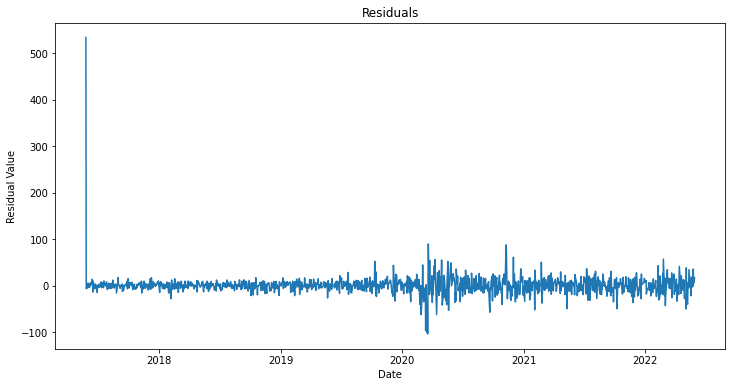

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


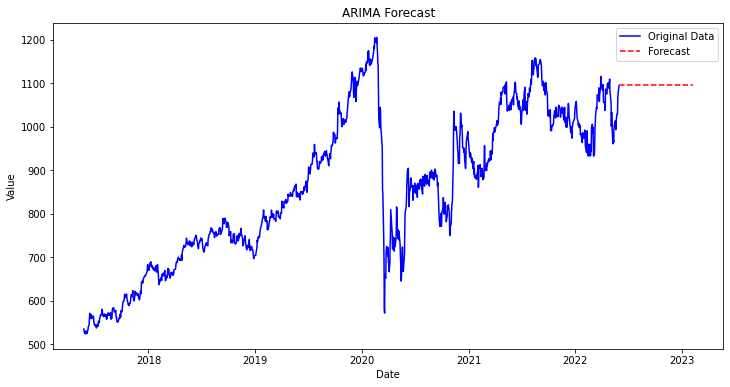

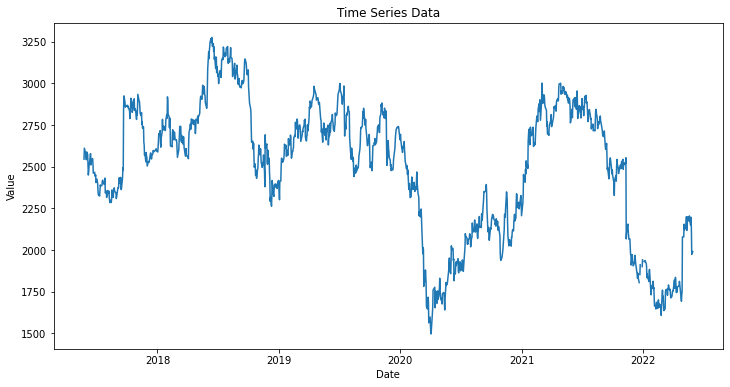

ADF Statistic: -2.0090983852810678
p-value: 0.2825980786092902
Critical Values:
1%: -3.4355381554821585
5%: -2.8638311143598556
10%: -2.567989813198476
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13423.847, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13425.636, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13425.624, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13421.948, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13426.818, Time=0.68 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.979 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6709.974
Date:                Thu, 12 Oct 2023   AIC                          13421.948
Time:                        12:59:05   BIC     

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


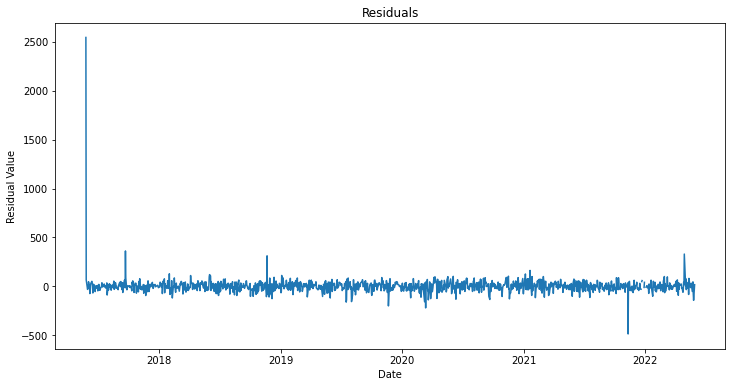

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


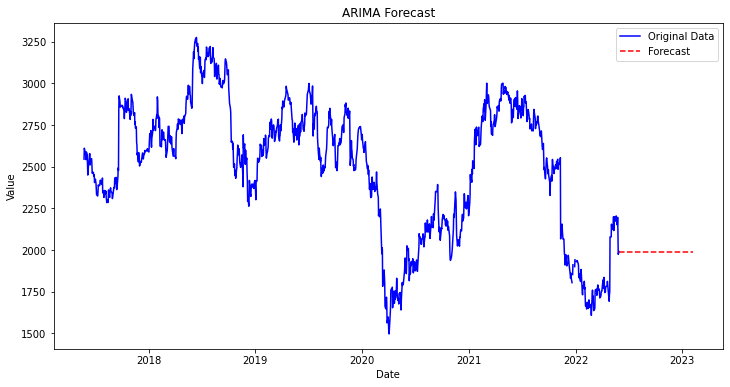

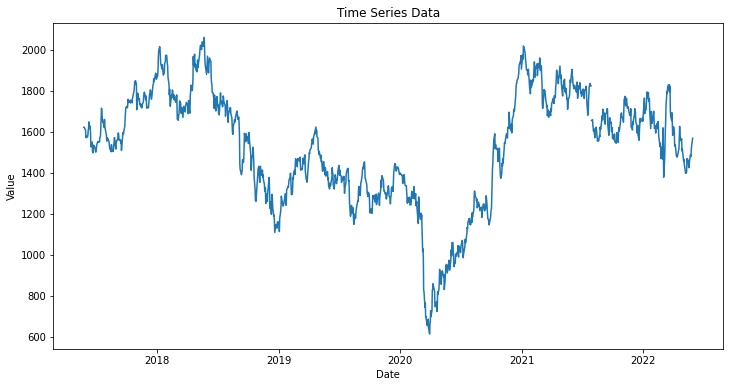

ADF Statistic: -2.1949959067966565
p-value: 0.20806666470123075
Critical Values:
1%: -3.4355258362116787
5%: -2.8638256788102323
10%: -2.567986918482913
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12532.137, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12534.136, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12534.136, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12530.139, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12536.038, Time=0.68 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.130 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1267
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6264.070
Date:                Thu, 12 Oct 2023   AIC                          12530.139
Time:                        12:59:08   BIC    

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


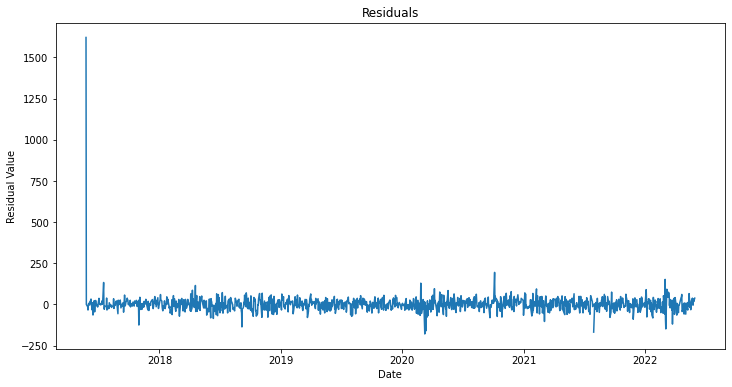

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


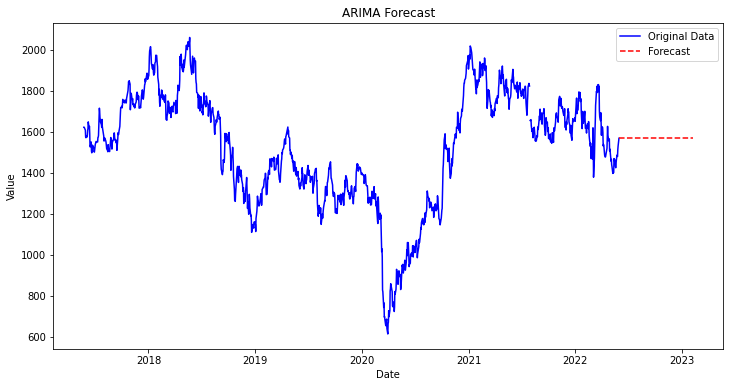

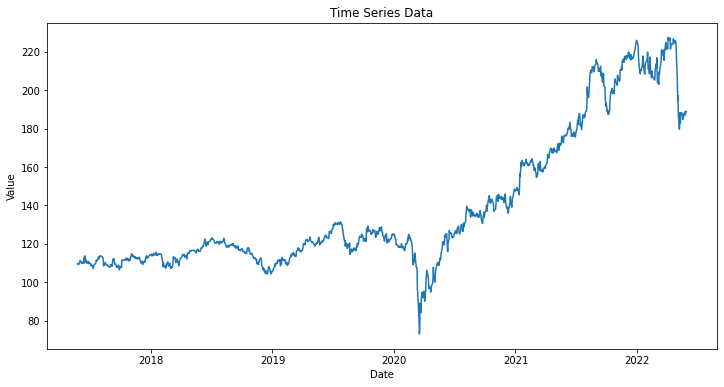

ADF Statistic: -0.5300037120503958
p-value: 0.8860272981588513
Critical Values:
1%: -3.4356175602072545
5%: -2.8638661490437025
10%: -2.5680084710921105
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5304.177, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5301.185, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5301.549, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5303.468, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5301.441, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5302.044, Time=0.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5303.243, Time=0.57 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5300.325, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5300.498, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5301.108, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5300.707, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5302.32

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


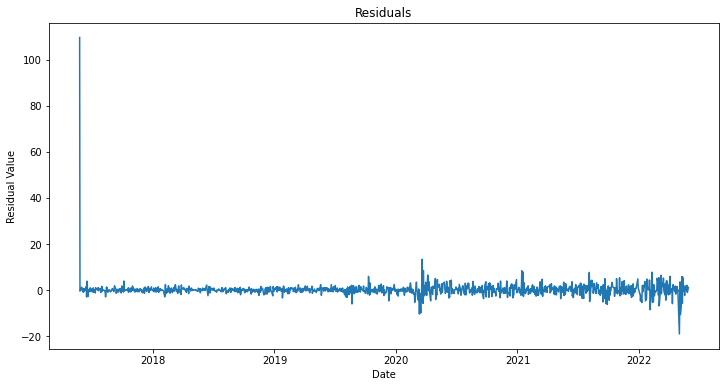

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


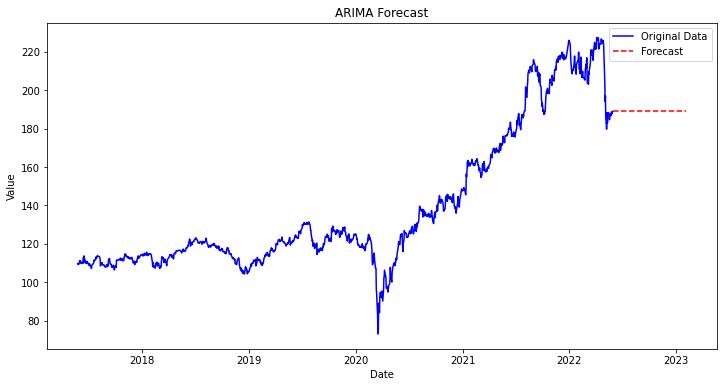

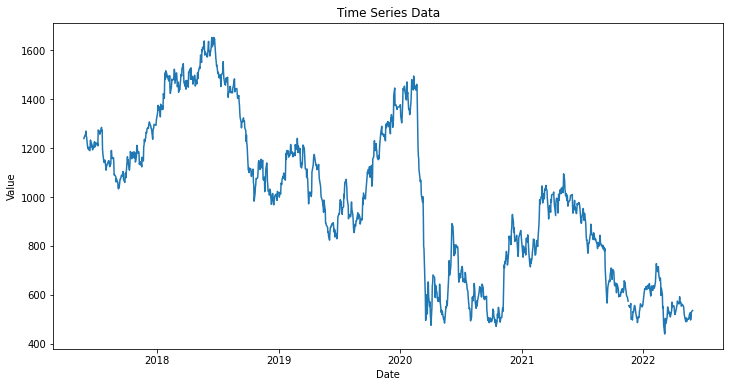

ADF Statistic: -1.5153413645019695
p-value: 0.52590899607831
Critical Values:
1%: -3.4355340425478706
5%: -2.863829299639741
10%: -2.5679888467643406
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12016.574, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12015.538, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12015.822, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12015.080, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12015.814, Time=0.48 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.931 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1267
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6006.540
Date:                Thu, 12 Oct 2023   AIC                          12015.080
Time:                        12:59:13   BIC       

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


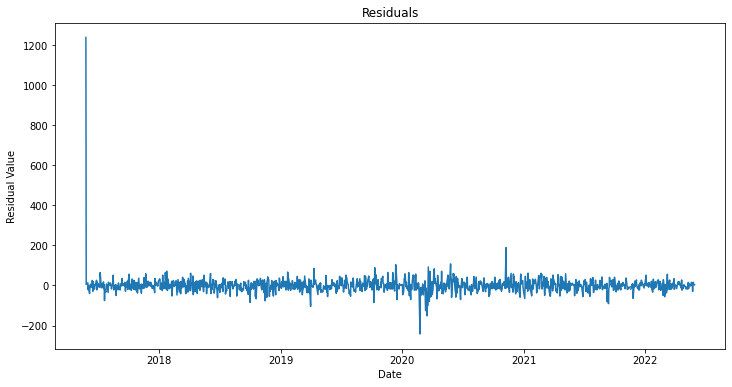

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


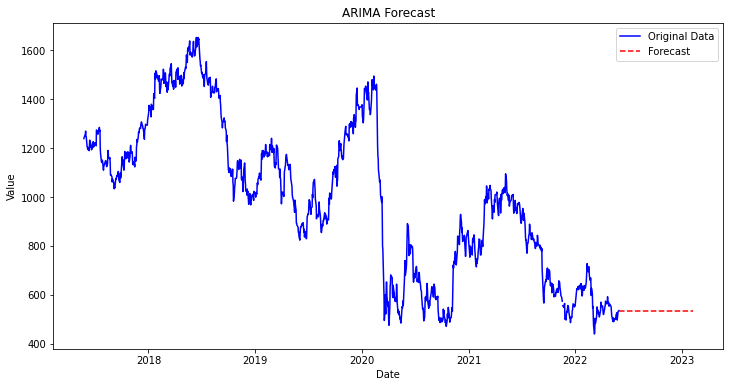

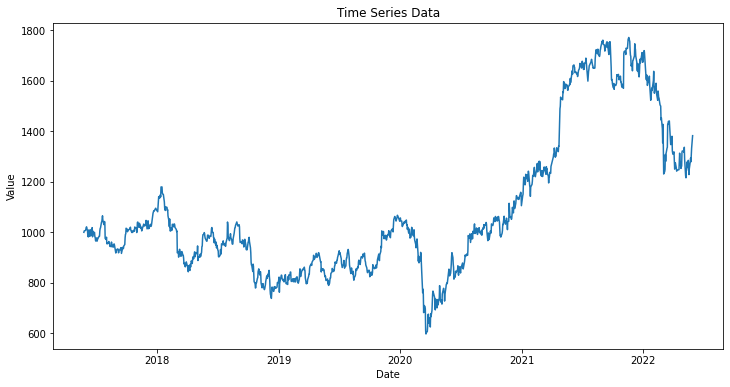

ADF Statistic: -1.0488520388464857
p-value: 0.7350325222177814
Critical Values:
1%: -3.4355217427788793
5%: -2.8638238726872296
10%: -2.5679859566283705
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11196.827, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11198.782, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11198.781, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11195.114, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11200.372, Time=0.92 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.350 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5596.557
Date:                Thu, 12 Oct 2023   AIC                          11195.114
Time:                        12:59:16   BIC    

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


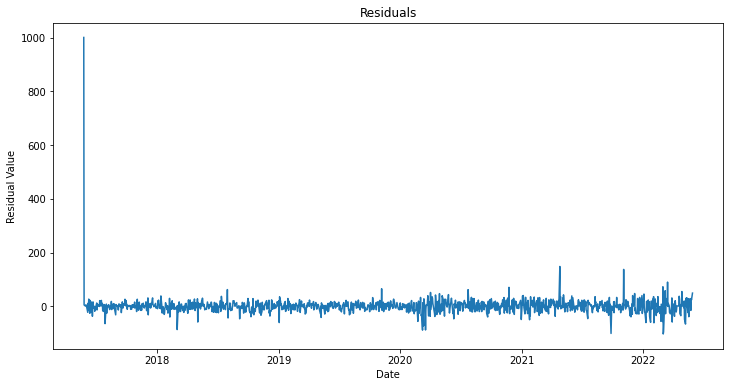

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


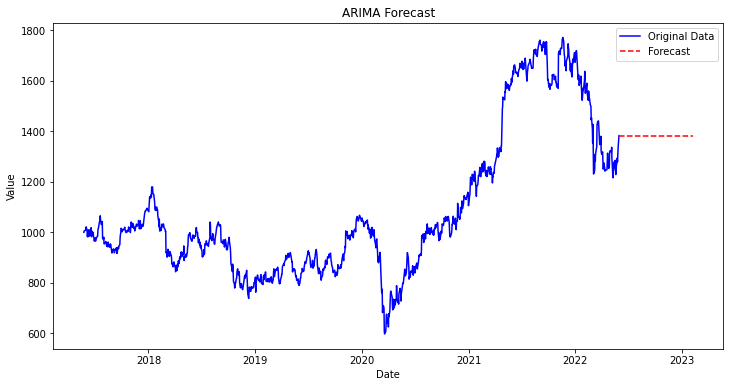

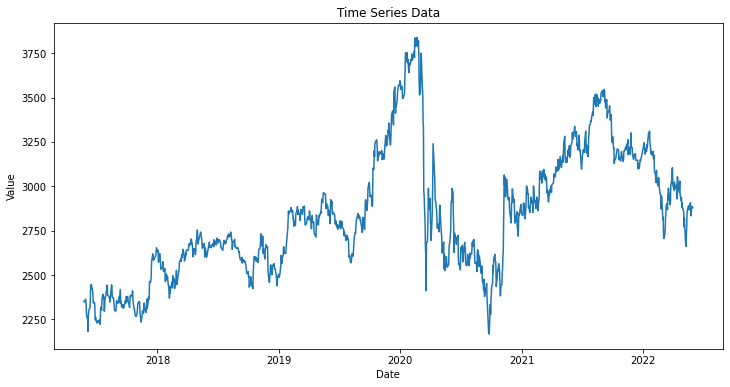

ADF Statistic: -2.235580266055755
p-value: 0.19358615998467432
Critical Values:
1%: -3.435592223709696
5%: -2.8638549702604803
10%: -2.56800251776
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13283.262, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13285.262, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13285.265, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13281.367, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13286.218, Time=0.62 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.929 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6639.684
Date:                Thu, 12 Oct 2023   AIC                          13281.367
Time:                        12:59:18   BIC          

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


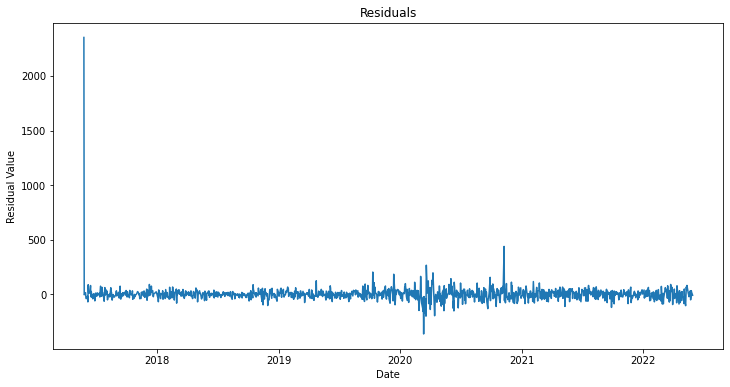

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


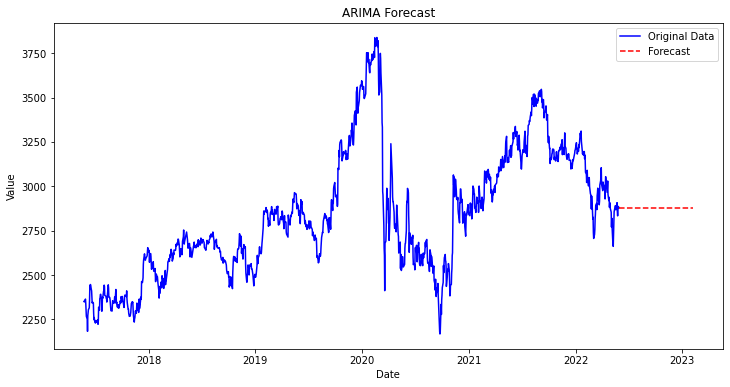

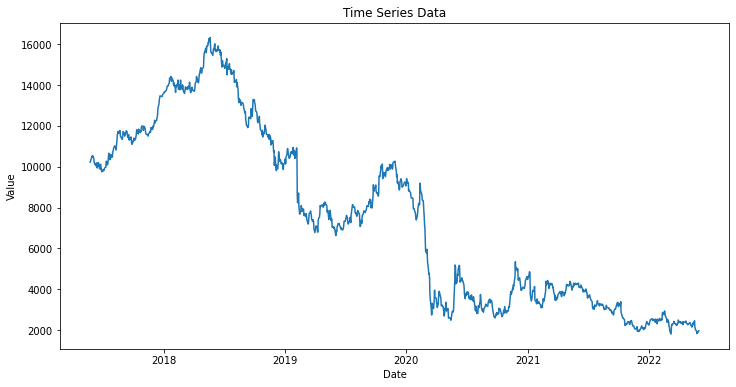

ADF Statistic: -0.48294354643028725
p-value: 0.8953021913180542
Critical Values:
1%: -3.4355258362116787
5%: -2.8638256788102323
10%: -2.567986918482913
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16918.123, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16916.135, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16916.070, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16917.586, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16917.980, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16918.006, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16920.009, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=16915.386, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16917.289, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=16917.340, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=16915.445, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


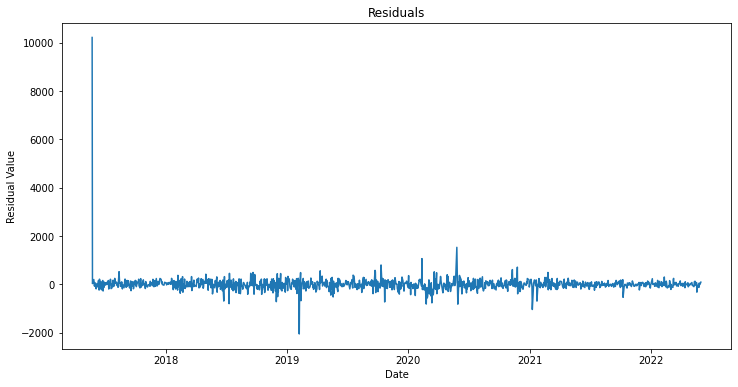

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


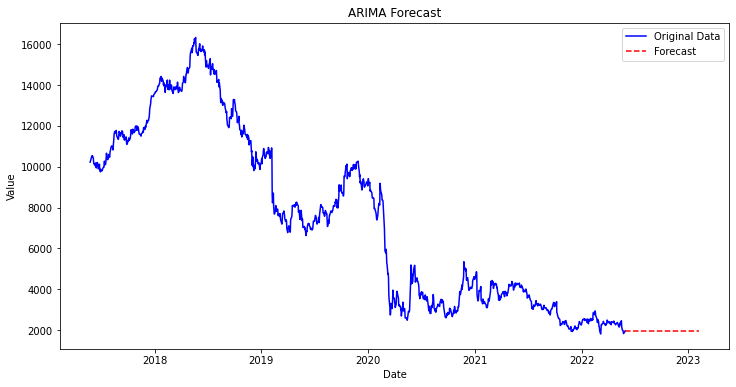

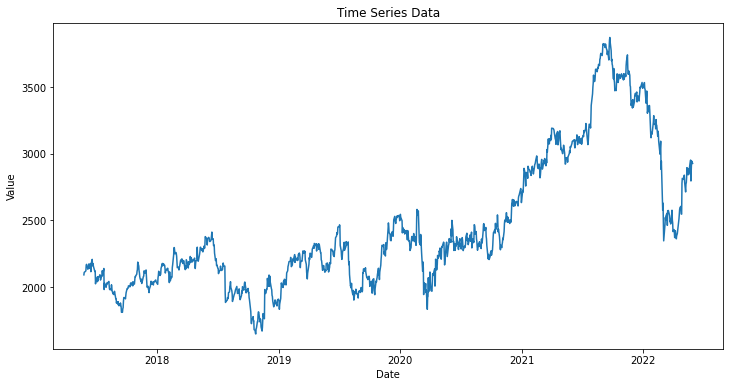

ADF Statistic: -1.3230012103113786
p-value: 0.6185846460651357
Critical Values:
1%: -3.4355258362116787
5%: -2.8638256788102323
10%: -2.567986918482913
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13161.575, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13155.171, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13155.590, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13159.866, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13156.534, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13156.672, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13158.471, Time=0.51 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=13153.515, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=13154.862, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=13154.993, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=13153.934, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : A

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


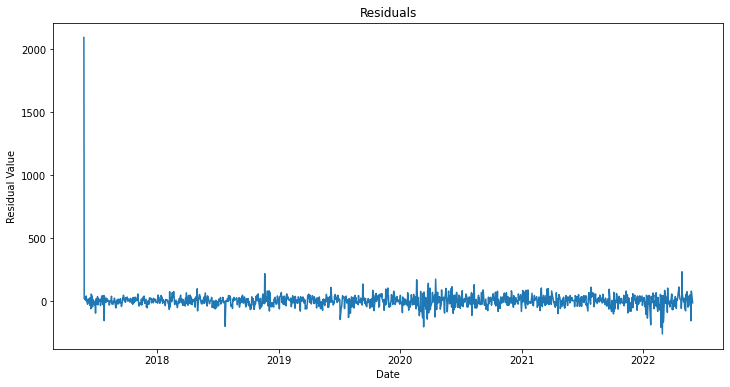

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


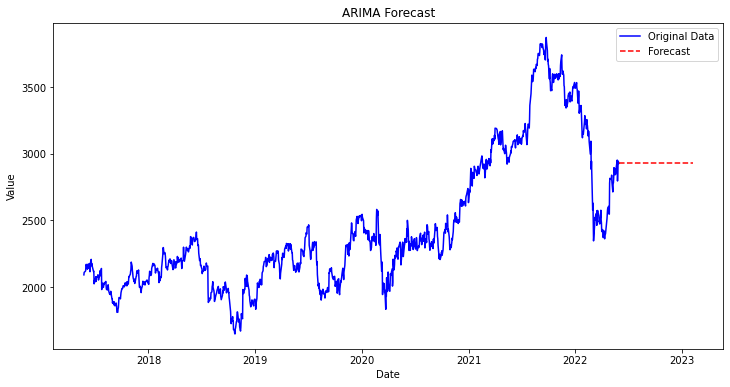

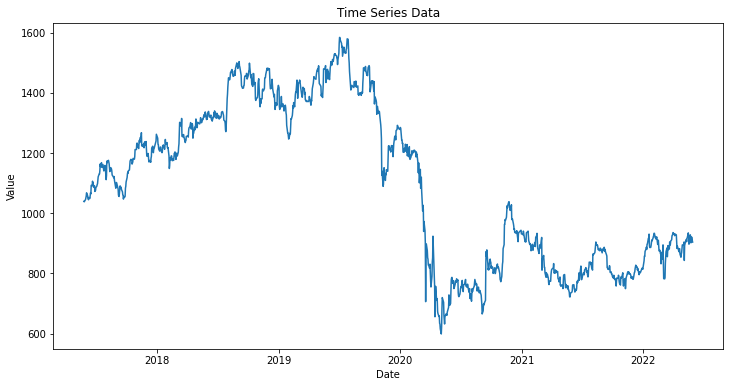

ADF Statistic: -1.3116871481580532
p-value: 0.6238086119633903
Critical Values:
1%: -3.4356006420838963
5%: -2.8638586845641063
10%: -2.5680044958343604
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11231.858, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11232.578, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11232.399, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11229.893, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11231.729, Time=0.51 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.959 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5613.947
Date:                Thu, 12 Oct 2023   AIC                          11229.893
Time:                        12:59:25   BIC    

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


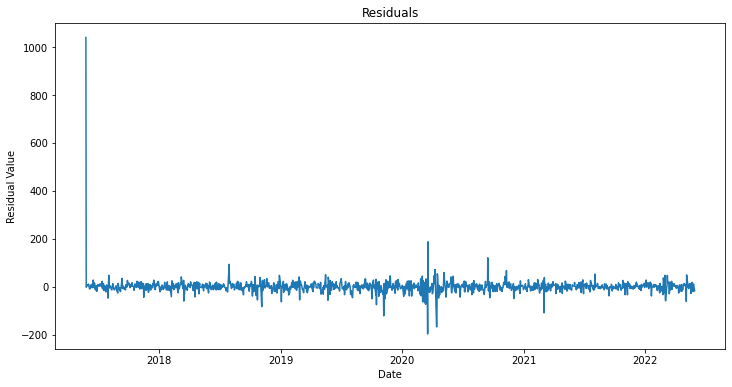

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


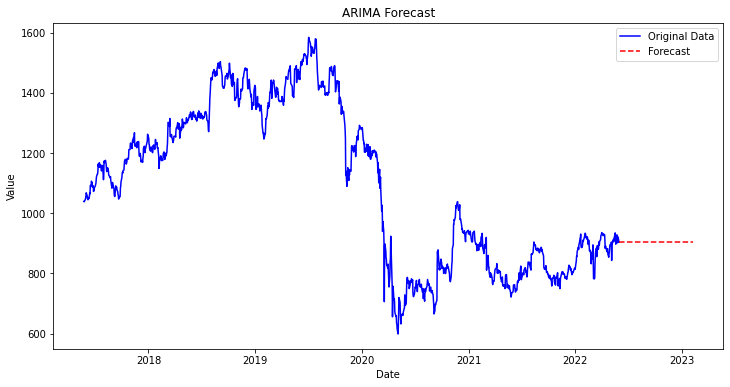

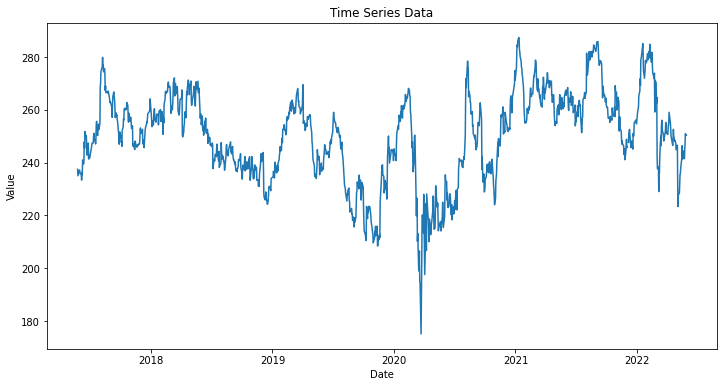

ADF Statistic: -3.7372082223595084
p-value: 0.0036192067026663095
Critical Values:
1%: -3.4355588184378574
5%: -2.8638402312881497
10%: -2.5679946684494275
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6970.038, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6965.835, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6966.211, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6968.047, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6966.751, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6967.276, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6968.689, Time=0.61 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6963.846, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=6964.762, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6965.287, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6964.222, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6966

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


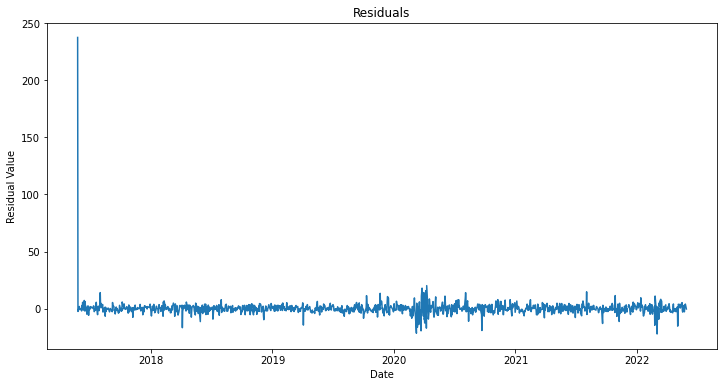

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


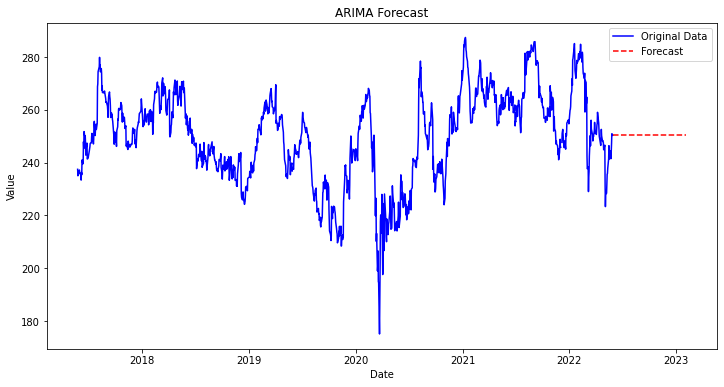

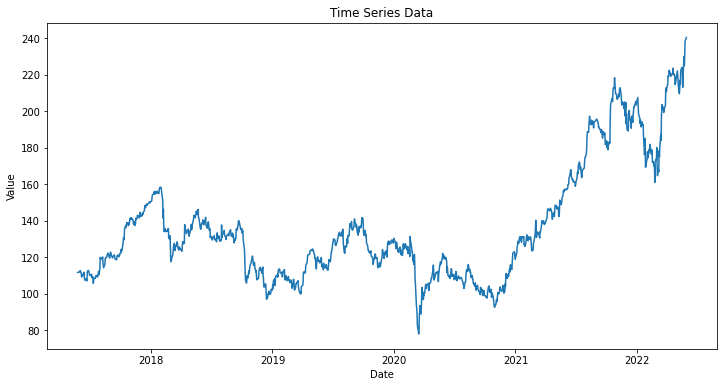

ADF Statistic: 0.021660951767005877
p-value: 0.9602871911611552
Critical Values:
1%: -3.435550533536195
5%: -2.863836575823745
10%: -2.567992721718317
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5992.318, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5991.452, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5991.694, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5992.294, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5991.213, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5987.165, Time=0.23 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=5988.347, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5987.553, Time=0.76 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5988.951, Time=0.83 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=5989.462, Time=1.07 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=5986.917, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5991.206,

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


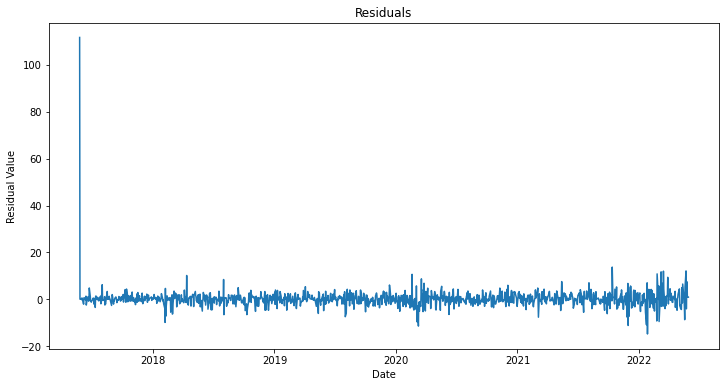

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


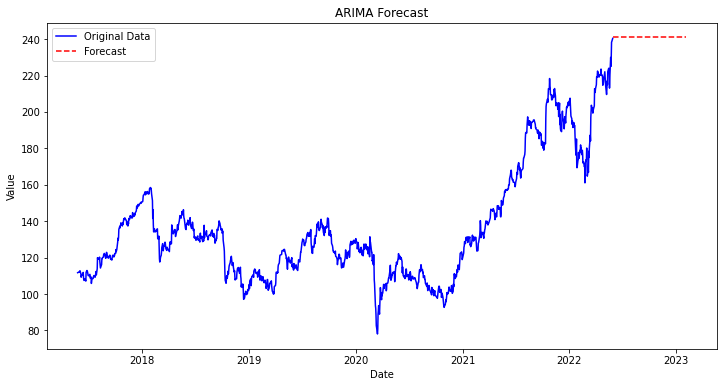

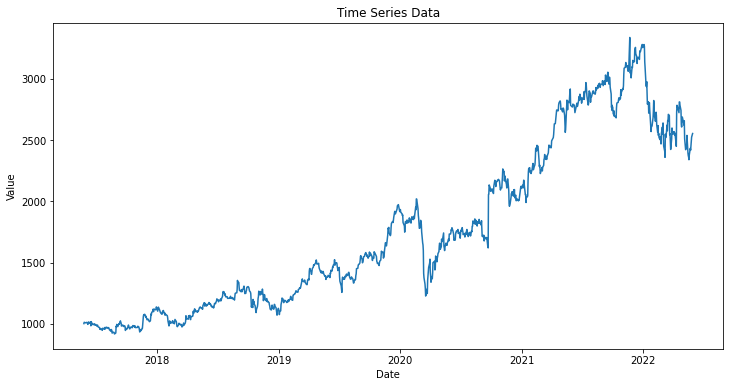

ADF Statistic: -0.9597265566277863
p-value: 0.7676683683016716
Critical Values:
1%: -3.4355217427788793
5%: -2.8638238726872296
10%: -2.5679859566283705
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12793.859, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12795.835, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12795.835, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12793.199, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12797.827, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.638 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6395.599
Date:                Thu, 12 Oct 2023   AIC                          12793.199
Time:                        12:59:37   BIC    

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


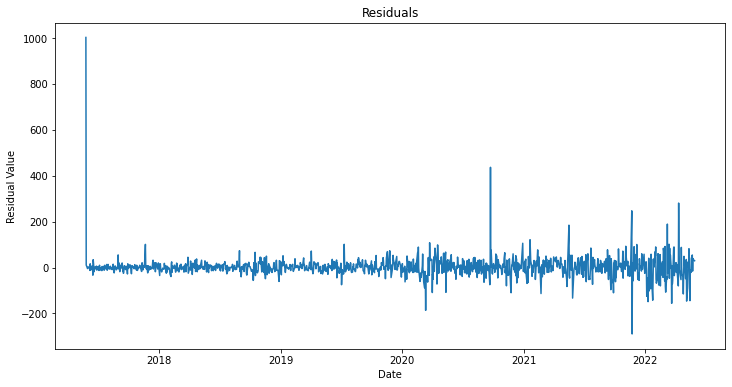

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


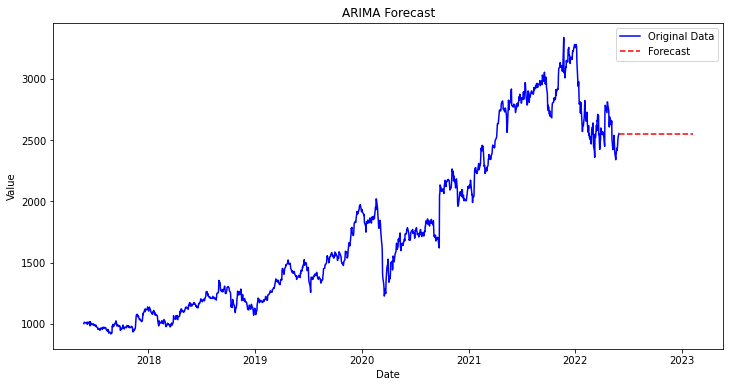

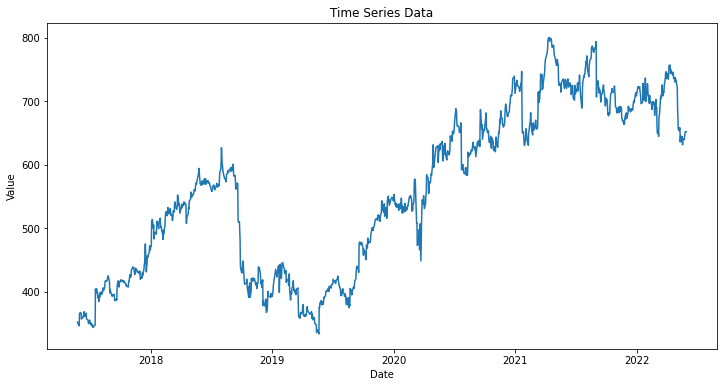

ADF Statistic: -1.7326309457686813
p-value: 0.41438326853449087
Critical Values:
1%: -3.4355258362116787
5%: -2.8638256788102323
10%: -2.567986918482913
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9531.563, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9528.607, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9528.345, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9530.220, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9528.958, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9529.545, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9530.957, Time=0.64 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=9527.101, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=9527.799, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=9528.343, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=9527.351, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=9529.79

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


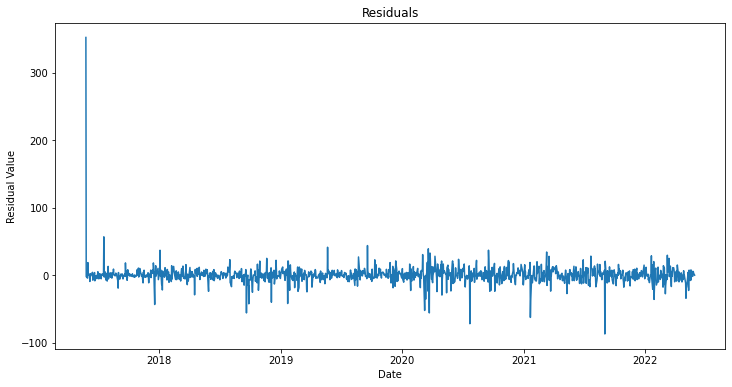

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


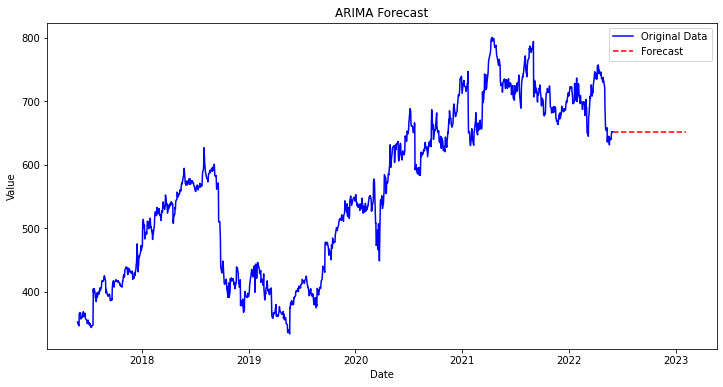

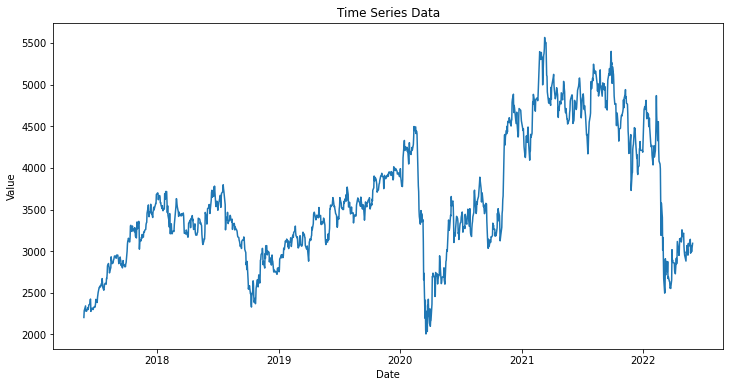

ADF Statistic: -2.6230663241360435
p-value: 0.08832301889765065
Critical Values:
1%: -3.4355464009607255
5%: -2.8638347524449888
10%: -2.5679917506718044
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15297.457, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15298.807, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15298.845, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15295.518, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15300.459, Time=0.31 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.583 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -7646.759
Date:                Thu, 12 Oct 2023   AIC                          15295.518
Time:                        12:59:42   BIC   

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


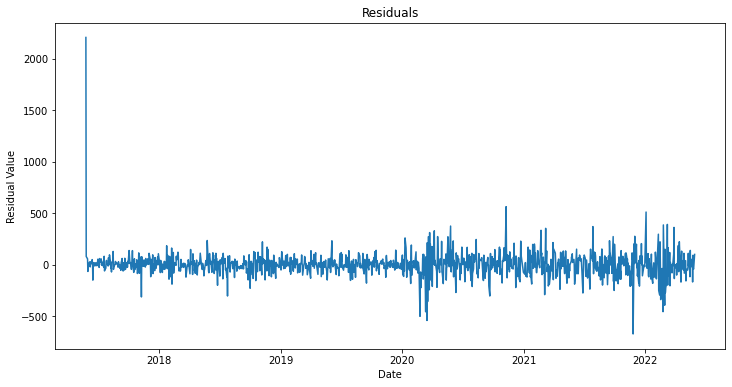

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


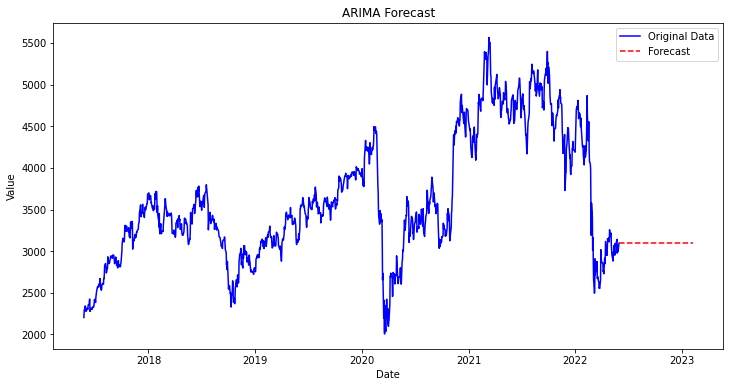

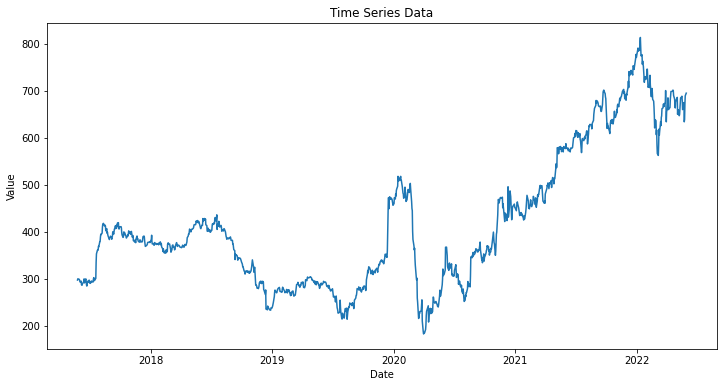

ADF Statistic: -0.6409780897599282
p-value: 0.8614512726214871
Critical Values:
1%: -3.4355217427788793
5%: -2.8638238726872296
10%: -2.5679859566283705
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9465.197, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9466.870, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9466.867, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9464.414, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9468.850, Time=0.97 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.331 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4731.207
Date:                Thu, 12 Oct 2023   AIC                           9464.414
Time:                        12:59:44   BIC         

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


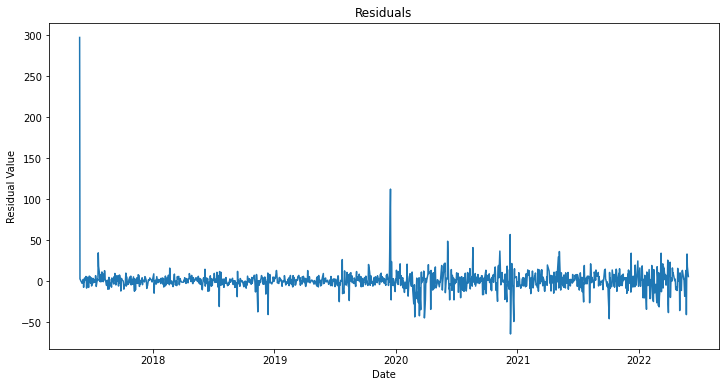

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


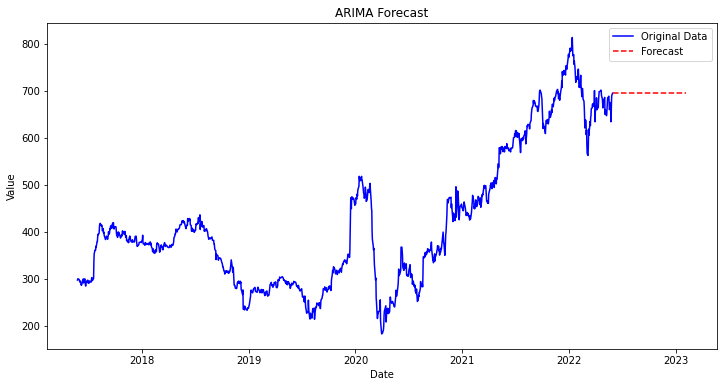

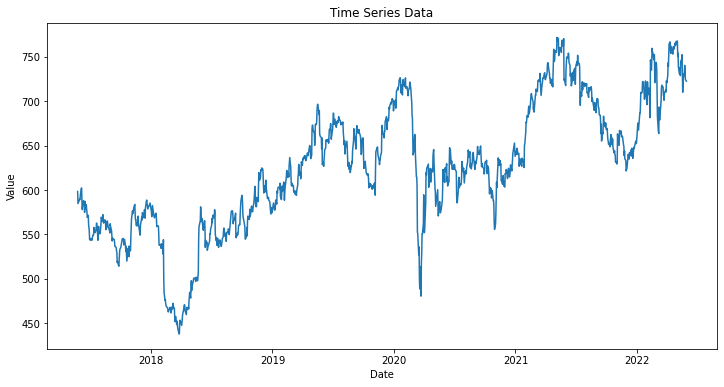

ADF Statistic: -1.8818554054635939
p-value: 0.34064444913906644
Critical Values:
1%: -3.4355588184378574
5%: -2.8638402312881497
10%: -2.5679946684494275
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9146.198, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9148.167, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9148.168, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9144.351, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9150.198, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.668 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4571.175
Date:                Thu, 12 Oct 2023   AIC                           9144.351
Time:                        12:59:46   BIC        

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


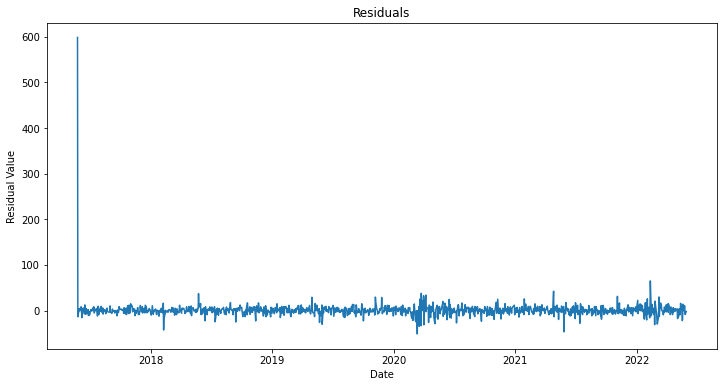

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


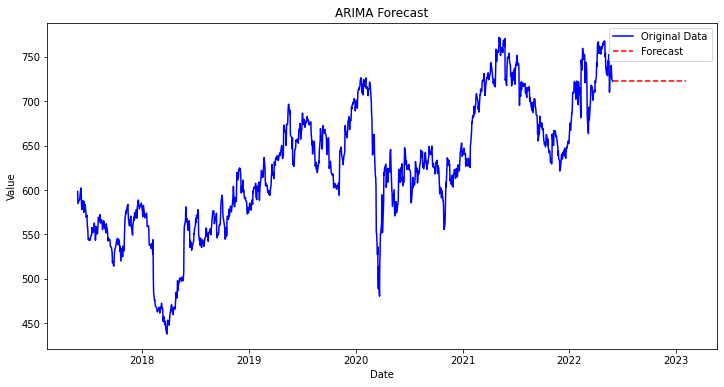

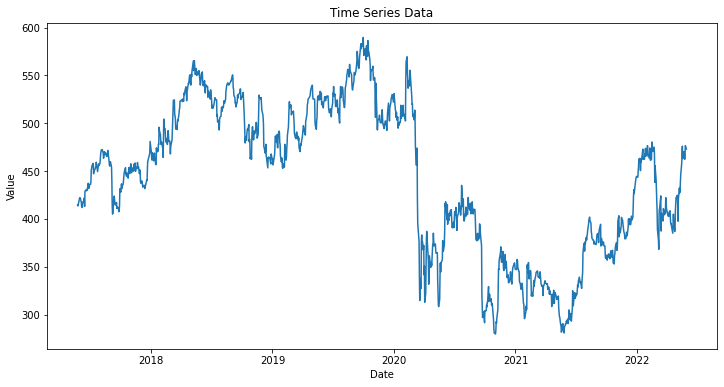

ADF Statistic: -2.0333011422335394
p-value: 0.2721652280581235
Critical Values:
1%: -3.4355258362116787
5%: -2.8638256788102323
10%: -2.567986918482913
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9038.587, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9038.799, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9038.777, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9036.624, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9040.769, Time=0.73 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.213 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4517.312
Date:                Thu, 12 Oct 2023   AIC                           9036.624
Time:                        12:59:48   BIC          

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


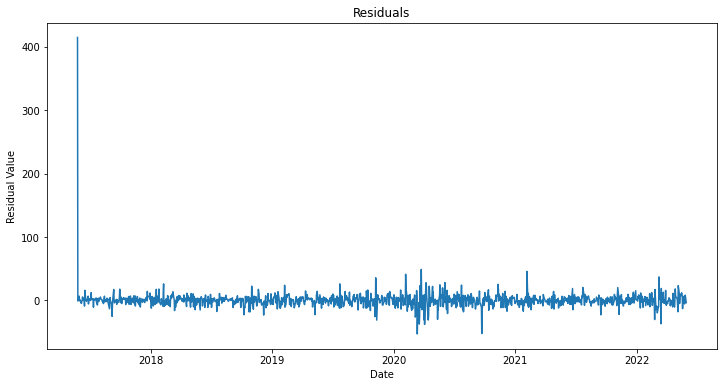

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


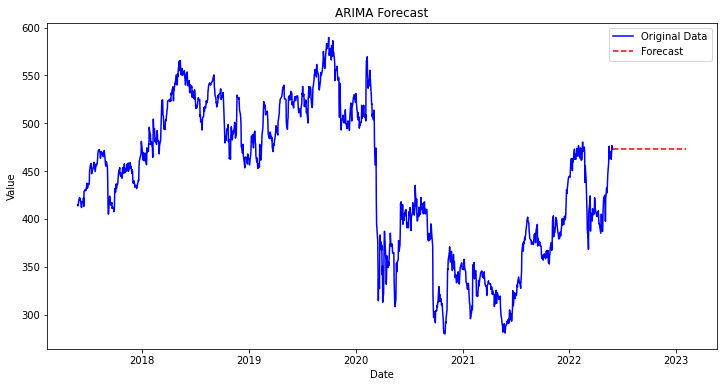

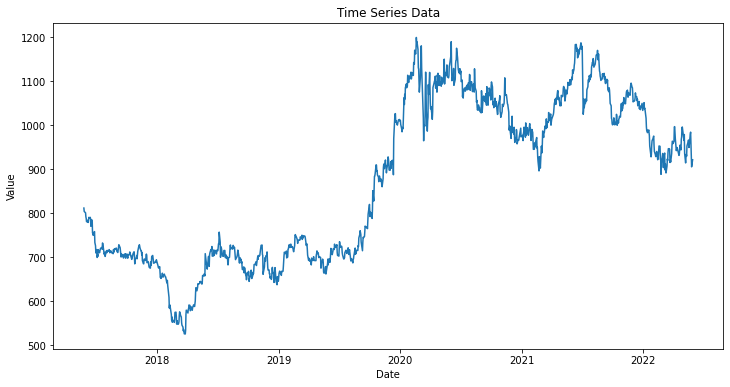

ADF Statistic: -1.255080188337083
p-value: 0.649464627973288
Critical Values:
1%: -3.4355964295197743
5%: -2.863856825923603
10%: -2.5680035060041626
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10436.194, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10437.587, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10437.516, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10434.237, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10424.703, Time=0.54 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10421.963, Time=0.78 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10436.250, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10420.841, Time=0.86 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=10433.729, Time=0.50 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=10418.600, Time=1.21 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=10424.963, Time=0.49 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


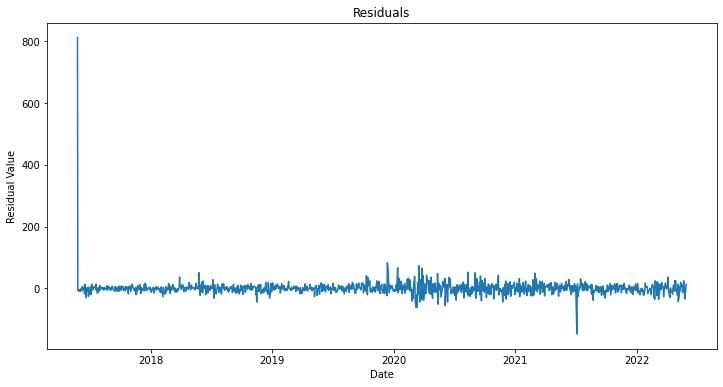

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


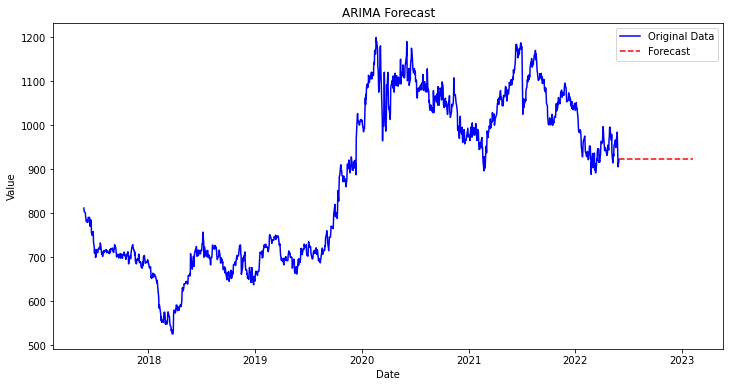

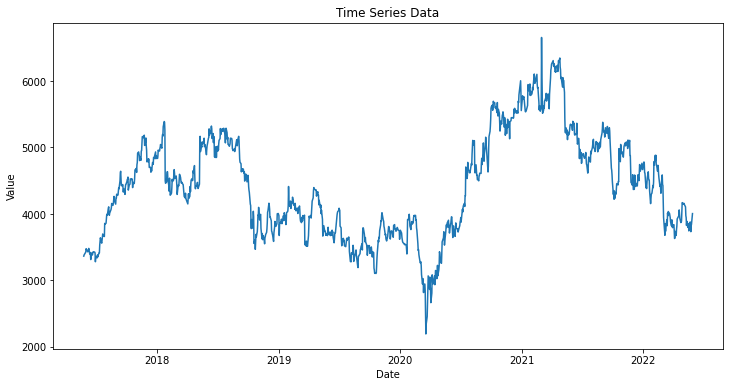

ADF Statistic: -2.590699111133451
p-value: 0.09493484936767183
Critical Values:
1%: -3.4355217427788793
5%: -2.8638238726872296
10%: -2.5679859566283705
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15390.932, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15392.845, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15392.843, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15388.962, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15391.168, Time=0.63 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.911 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -7693.481
Date:                Thu, 12 Oct 2023   AIC                          15388.962
Time:                        13:00:18   BIC    

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


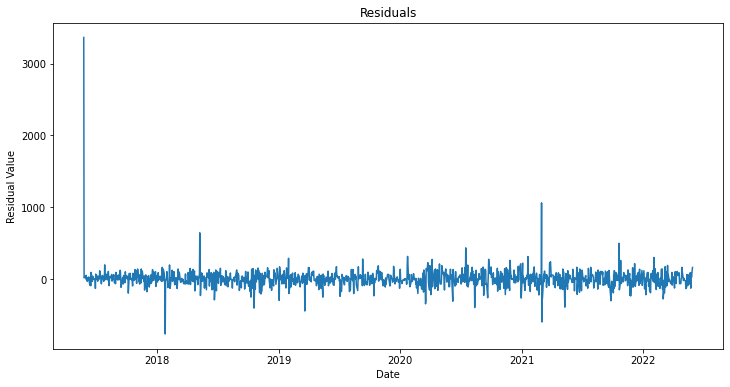

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


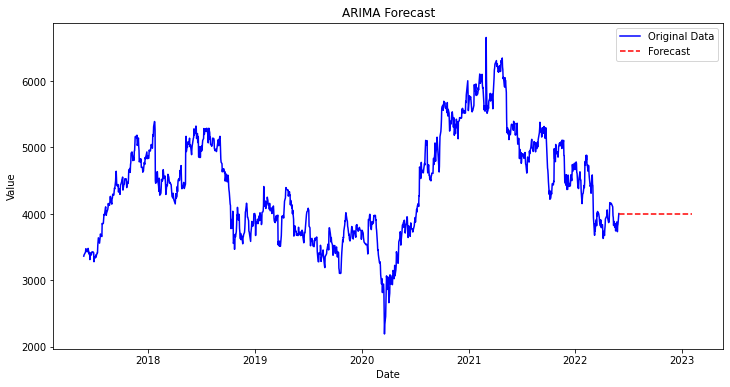

optimal_p  optimal_q  optimal_d  deviations from last known price  \
ICP.L         0.0        0.0        1.0                       1464.248291   
ABDN.L        0.0        0.0        1.0                        175.403336   
SMDS.L        0.0        0.0        1.0                        282.856781   
HL.L          0.0        0.0        1.0                        824.121399   
DPH.L         1.0        0.0        1.0                       3568.588158   
HIK.L         0.0        0.0        1.0                       1640.628174   
HWDN.L        0.0        0.0        1.0                        655.644653   
IDS.L         0.0        0.0        1.0                        313.700653   
ITV.L         0.0        0.0        1.0                         65.962578   
CCL.L         1.0        1.0        1.0                       1014.456420   
INVP.L        2.0        1.0        1.0                        434.391599   
CNA.L         0.0        0.0        1.0                         74.384430   
CTEC.L        0.0        0.0        1.0                        212.978073   
UTG.L         1.0        0.0        1.0                       1096.380594   
JMAT.L        0.0        0.0        1.0                       1990.937744   
WEIR.L        0.0        0.0        1.0                       1567.920288   
BBOX.L        1.0        0.0        1.0                        188.998296   
EZJ.L         0.0        0.0        1.0                        535.200012   
IMI.L         0.0        0.0        1.0                       1383.135132   
DLN.L         0.0        0.0        1.0                       2879.104248   
TUI.L         0.0        1.0        1.0                       1975.828040   
SXS.L         1.0        0.0        1.0                       2929.433769   
HSX.L         0.0        0.0        1.0                        904.025940   
DLG.L         1.0        0.0        1.0                        250.405742   
EMG.L         3.0        0.0        1.0                        240.889988   
DPLM.L        0.0        0.0        1.0                       2553.907471   
IGG.L         0.0        1.0        1.0                        652.185704   
WIZZ.L        0.0        0.0        1.0                       3094.000000   
FRAS.L        0.0        0.0        1.0                        695.000000   
TATE.L        0.0        0.0        1.0                        722.515137   
BEZ.L         0.0        0.0        1.0                        473.095398   
PNN.L         2.0        4.0        1.0                        922.990838   
RSW.L         0.0        0.0        1.0                       4005.439697   

        prediction_price  
ICP.L        1464.248291  
ABDN.L        175.403336  
SMDS.L        282.856781  
HL.L          824.121399  
DPH.L        3568.588158  
HIK.L        1640.628174  
HWDN.L        655.644653  
IDS.L         313.700653  
ITV.L          65.962578  
CCL.L        1014.456420  
INVP.L        434.391599  
CNA.L          74.384430  
CTEC.L        212.978073  
UTG.L        1096.380594  
JMAT.L       1990.937744  
WEIR.L       1567.920288  
BBOX.L        188.998296  
EZJ.L         535.200012  
IMI.L        1383.135132  
DLN.L        2879.104248  
TUI.L        1975.828040  
SXS.L        2929.433769  
HSX.L         904.025940  
DLG.L         250.405742  
EMG.L         240.889988  
DPLM.L       2553.907471  
IGG.L         652.185704  
WIZZ.L       3094.000000  
FRAS.L        695.000000  
TATE.L        722.515137  
BEZ.L         473.095398  
PNN.L         922.990838  
RSW.L        4005.439697

In [7]:
"""
ARIMA


#inputs = df, dataframe of close prices.
#outputs = dataframe of (params_dict). contains the optimized params (p, d, q) using auto-arima
        # = plots of original time series
        # = plots of results.summary() of fitting optimized params into ARIMA(p,d,q)
        # = plots of residuals
        # = plots of forecast (3 days look-ahead) 
"""


params_dict = {}


for column in df.columns:

    # Visualize your time series data
    plt.figure(figsize=(12, 6))
    plt.plot(df[column])
    plt.title('Time Series Data')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.show()

    # Check for stationarity using Augmented Dickey-Fuller test
    from statsmodels.tsa.stattools import adfuller

    result = adfuller(df[column].dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'{key}: {value}')
    
    
    
    # If the data is not stationary, apply differencing to make it stationary
    #while result[1] > 0.05:  # Adjust the significance level as needed
    
    data_diff = df[column].diff().dropna() #first differencing
    d = 1
    print("number of differencing was {}".format(d))
    
    while adfuller(data_diff)[1] > 0.05:
        data_diff = data_diff.diff().dropna()
        d += 1
        print("number of differencing was {}".format(d))

    else:
        #data_diff = data
        data_diff = df[column]
#         plt.figure(figsize=(12, 6))
#         plt.plot(data_diff)
#         plt.title('Differenced Time Series Data')
#         plt.xlabel('Date')
#         plt.ylabel('Value')
#         plt.show()

    # Fit an ARIMA model

    p_range = range(0, 5)
    q_range = range(0, 5)

    
    # Find the best ARIMA model using auto_arima
    best_model = auto_arima(df[column].dropna(), start_p=0, d=1, start_q=0,
                            max_p=4, max_d=4, max_q=4,
                            seasonal=True, trace=True,
                            stepwise=True, error_action='ignore', suppress_warnings=True)

    print(best_model.summary())
    
    p_optimal = best_model.get_params()['order'][0]
    d_optimal = best_model.get_params()['order'][1]
    q_optimal = best_model.get_params()['order'][2]
                                                 
    
    for differencing_count in range(d_optimal):
        data_diff = data_diff.diff().dropna()
    
    
    """to edit"""
    #model = sm.tsa.ARIMA(data_diff, order=(p_optimal, d_optimal, q_optimal))
    model = sm.tsa.ARIMA(df[column], order=(p_optimal, d_optimal, q_optimal))
    results = model.fit()

    # Print model summary
    #print(results.summary())

    # Plot the residuals to check for randomness
    # residuals should show no predictability in variance and have mean of 0
    residuals = results.resid
    plt.figure(figsize=(12, 6))
    plt.plot(residuals)
    plt.title('Residuals')
    plt.xlabel('Date')
    plt.ylabel('Residual Value')
    plt.show()

    # Forecast future values
    forecast_steps = 3  # Number of time steps to forecast ahead
    forecast, stderr, conf_int = results.forecast(steps=forecast_steps)
    
    #create dictionary to store params
    """to edit"""
    params_dict[column] = {"optimal_p": p_optimal,
                           "optimal_q": q_optimal, 
                           "optimal_d": d_optimal,
                          "deviations from last known price" : forecast,
                          #"prediction_price" : forecast+df[column].iloc[-1]
                          "prediction_price" : forecast}

    
    last_date = df[column].index[-1]
    additional_x = 250
    forecast_index = pd.date_range(start=last_date, periods=forecast_steps+additional_x, freq='D')
    
    
    """to edit"""
    # Create a DataFrame for the forecasted values
    #forecast_df = pd.DataFrame({'Forecast': df[column].iloc[-1]+forecast}, index=forecast_index)
    forecast_df = pd.DataFrame({'Forecast': forecast}, index=forecast_index)
    
    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the original data
    ax.plot(df[column], label='Original Data', color='blue')

    # Plot the forecasted values
    ax.plot(forecast_df, label='Forecast', linestyle='--', color='red')

    ax.set_title('ARIMA Forecast')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()

    # Show the plot
    plt.show() 
    
params_df = pd.DataFrame(params_dict).T
    
display(params_df)
    


In [8]:
file = pd.read_csv("prediction_result_3days_200622.csv")
file

Unnamed: 0  Actual Price Predicted Price       MSE       MAE  R2  \
0       CCL.L   1011.500000     [1102.1017]  0.004354  0.065982   1   
1       PNN.L    921.890503      [978.6994]  0.094318  0.307112   1   
2       IGG.L    652.198731      [628.6662]  0.035130  0.187431   1   
3       ITV.L     65.962585     [66.964294]  0.002242  0.047346   1   
4      INVP.L    433.472778      [401.9024]  0.167294  0.409016   1   
5       EMG.L    240.397629      [223.5084]  0.285668  0.534479   1   
6      TATE.L    722.515076      [747.0776]  0.113386  0.336728   1   
7       RSW.L   4005.439697     [3899.5273]  0.019304  0.138940   1   
8       IDS.L    313.700653     [276.65097]  0.108747  0.329769   1   
9       SXS.L   2927.939453     [2899.7961]  0.003010  0.054867   1   
10      HSX.L    904.025879     [924.79584]  0.005985  0.077362   1   
11     FRAS.L    695.000000      [648.7346]  0.101715  0.318928   1   
12      BEZ.L    473.095398      [459.9702]  0.027568  0.166035   1   
13     WIZZ.L   3094.000000     [3054.6003]  0.002874  0.053610   1   
14      DLN.L   2879.104248     [2870.5718]  0.000610  0.024702   1   
15      DLG.L    250.364975      [232.5869]  1.044022  1.021774   1   
16     ABDN.L    175.403336      [163.5097]  0.077741  0.278821   1   
17     DPLM.L   2553.907471     [2410.2227]  0.045431  0.213145   1   
18     BBOX.L    188.927795     [208.25749]  0.279559  0.528733   1   
19      IMI.L   1383.135132       [1250.15]  0.208410  0.456519   1   
20     HWDN.L    660.338989     [637.03265]  0.022085  0.148612   1   
21      HIK.L   1640.628174      [1627.581]  0.000760  0.027571   1   
22     JMAT.L   1990.937866     [1888.5277]  0.064393  0.253758   1   
23     SMDS.L    282.856812     [267.72086]  0.095043  0.308290   1   
24       HL.L    824.121399      [752.5042]  0.084401  0.290519   1   
25      EZJ.L    535.200012     [526.18634]  0.000791  0.028124   1   
26      DPH.L   3567.611328     [3383.6902]  0.043994  0.209748   1   
27     WEIR.L   1567.920288     [1492.0137]  0.072201  0.268702   1   
28      CNA.L     74.384422     [85.310745]  0.139973  0.374130   1   
29      ICP.L   1464.248291     [1264.2468]  0.236230  0.486035   1   
30     CTEC.L    212.978073     [172.95068]  1.607907  1.268033   1   
31      UTG.L   1094.273804      [984.9353]  0.442204  0.664984   1   
32      TUI.L   1970.500000      [1956.457]  0.000011  0.003248   1   

    Market Share      final_marketcap   
0      146260000   147,941,990,000.00   
1      261327008   240914886834.23047   
2      395398016    257878084065.0625   
3     4034409984   266120113306.78125   
4      645161984   279,660,157,671.13   
5     1199859968    288443491180.2617   
6      401665984   290209728829.28516   
7       72788496   291549931382.66016   
8      956193024    299958376095.6797   
9      102758000   300869202324.21875   
10     347103008    313790101878.2031   
11     454926016   316,173,581,120.00   
12     672462976   318139139236.83594   
13     103335000   319,718,490,000.00   
14     112291000   323297495117.43164   
15    1311399936   328,328,612,159.63   
16    1899229952    333131268597.6992   
17     134034000   342310433928.22266   
18    1903740032    359669407279.8203   
19     260858000   360,801,864,220.46   
20     548673024    362310190101.1875   
21     221079008   362708449166.77344   
22     183452992    365243508442.4922   
23    1377449984   389,621,110,507.25   
24     474319008    390896444410.0488   
25     758000000    405681609252.9297   
26     113888000   406,308,118,937.50   
27     259612000    407050921830.5664   
28    5493660160   408642737326.46484   
29     290612992    425529576882.9375   
30    2049789952    436560314277.9375   
31     435726016    476803564904.1328   
32     507431008   999,892,801,264.00

In [9]:
params_df["log_forecast/actual"] =\
(
    np.log(params_df["prediction_price"].values / file["Actual Price"].values)
)
params_df

optimal_p  optimal_q  optimal_d  deviations from last known price  \
ICP.L         0.0        0.0        1.0                       1464.248291   
ABDN.L        0.0        0.0        1.0                        175.403336   
SMDS.L        0.0        0.0        1.0                        282.856781   
HL.L          0.0        0.0        1.0                        824.121399   
DPH.L         1.0        0.0        1.0                       3568.588158   
HIK.L         0.0        0.0        1.0                       1640.628174   
HWDN.L        0.0        0.0        1.0                        655.644653   
IDS.L         0.0        0.0        1.0                        313.700653   
ITV.L         0.0        0.0        1.0                         65.962578   
CCL.L         1.0        1.0        1.0                       1014.456420   
INVP.L        2.0        1.0        1.0                        434.391599   
CNA.L         0.0        0.0        1.0                         74.384430   
CTEC.L        0.0        0.0        1.0                        212.978073   
UTG.L         1.0        0.0        1.0                       1096.380594   
JMAT.L        0.0        0.0        1.0                       1990.937744   
WEIR.L        0.0        0.0        1.0                       1567.920288   
BBOX.L        1.0        0.0        1.0                        188.998296   
EZJ.L         0.0        0.0        1.0                        535.200012   
IMI.L         0.0        0.0        1.0                       1383.135132   
DLN.L         0.0        0.0        1.0                       2879.104248   
TUI.L         0.0        1.0        1.0                       1975.828040   
SXS.L         1.0        0.0        1.0                       2929.433769   
HSX.L         0.0        0.0        1.0                        904.025940   
DLG.L         1.0        0.0        1.0                        250.405742   
EMG.L         3.0        0.0        1.0                        240.889988   
DPLM.L        0.0        0.0        1.0                       2553.907471   
IGG.L         0.0        1.0        1.0                        652.185704   
WIZZ.L        0.0        0.0        1.0                       3094.000000   
FRAS.L        0.0        0.0        1.0                        695.000000   
TATE.L        0.0        0.0        1.0                        722.515137   
BEZ.L         0.0        0.0        1.0                        473.095398   
PNN.L         2.0        4.0        1.0                        922.990838   
RSW.L         0.0        0.0        1.0                       4005.439697   

        prediction_price  log_forecast/actual  
ICP.L        1464.248291             0.369908  
ABDN.L        175.403336            -1.659338  
SMDS.L        282.856781            -0.835409  
HL.L          824.121399             2.525230  
DPH.L        3568.588158             2.108096  
HIK.L        1640.628174             1.920540  
HWDN.L        655.644653            -0.097119  
IDS.L         313.700653            -2.546969  
ITV.L          65.962578            -1.559352  
CCL.L        1014.456420            -1.059946  
INVP.L        434.391599            -0.732912  
CNA.L          74.384430            -2.234665  
CTEC.L        212.978073            -0.798108  
UTG.L        1096.380594            -1.037450  
JMAT.L       1990.937744            -0.368873  
WEIR.L       1567.920288             1.834586  
BBOX.L        188.998296             0.074650  
EZJ.L         535.200012            -1.562739  
IMI.L        1383.135132             1.990743  
DLN.L        2879.104248             0.733126  
TUI.L        1975.828040             1.095990  
SXS.L        2929.433769             0.579730  
HSX.L         904.025940            -0.789503  
DLG.L         250.405742            -0.121858  
EMG.L         240.889988            -1.229978  
DPLM.L       2553.907471             1.562739  
IGG.L         652.185704            -1.699322  
WIZZ.L       3094.000000             0.679715

<Axes: >

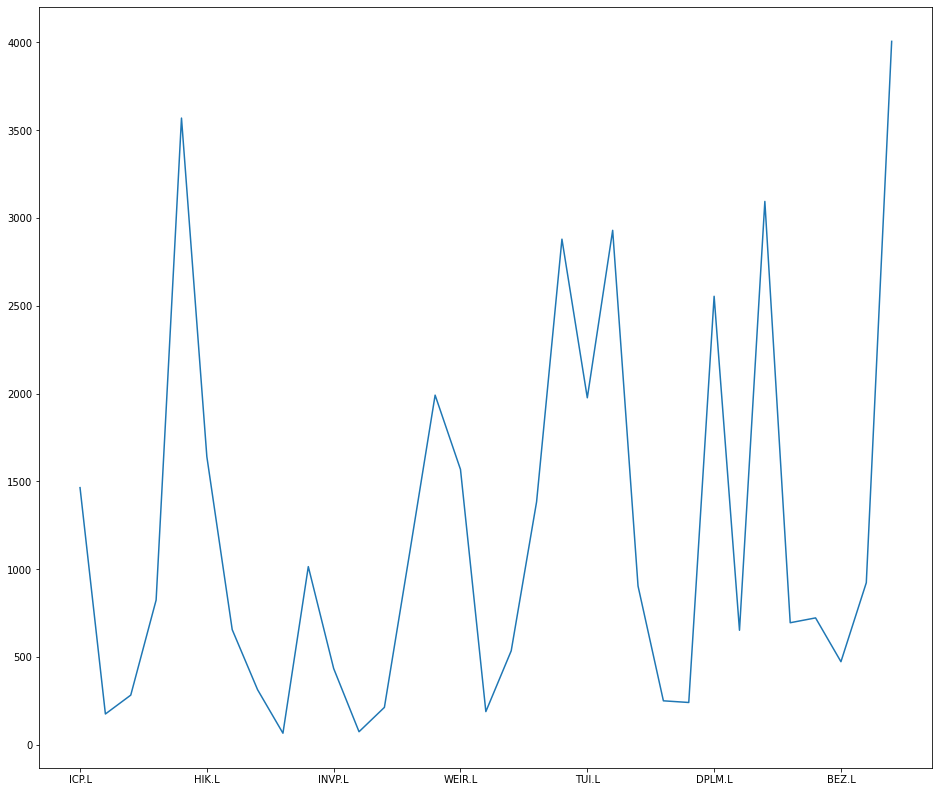

In [10]:
#however, this is not good analysis because the analysis should be factor in the stock price as a reference.
params_df["deviations from last known price"].plot(figsize=[16,14])

<Axes: >

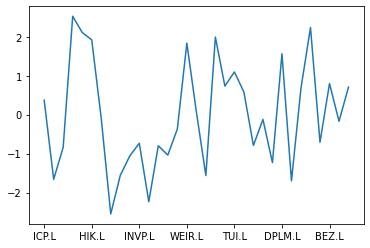

In [11]:
params_df["log_forecast/actual"].plot()

In [12]:
#can we use this mean as a measure of comparison between ARIMA and LSTM?
#larger mean away from 0 implies lower accuracy

abs(params_df["log_forecast/actual"]).mean()

1.1644642374389436

In [13]:
params_df.to_excel("params_df_edited.xlsx")